<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/MCFwith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import warnings
warnings.filterwarnings('ignore')

Устанавливаем класс под алгоритм

In [1]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-si2oxb5k
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-si2oxb5k
  Resolved https://github.com/Karasiari/graphmcf.git to commit df6ba7b4eb96acbb15f839863efc11dd155490b5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=32953 sha256=72221387739cb978971e762afe25a57998ab52027271c7971c6dd89a889f23dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-vkcnixof/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


Функции для решения MCF - дополнительная проверка наших результатов

In [37]:
import numpy as np

import cvxpy as cp
import networkx as nx

from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class Solution:
    problem: cp.Problem
    flow: np.ndarray
    add_bandwidth: Optional[np.ndarray] = None
    gamma: Optional[float] = None
    traffic_mat: Optional[float] = None

    def to_vector(self) -> np.ndarray:
        sol_parts = [self.flow.T.flatten()]
        if self.add_bandwidth is not None:
            sol_parts.append(self.add_bandwidth)
        if self.gamma is not None:
            sol_parts.append(self.gamma)
        return np.hstack(sol_parts)


def vector_to_solution(graph: nx.DiGraph, vec: np.ndarray, problem_type: str):
    m, n = graph.number_of_edges(), graph.number_of_nodes()
    flow = vec[: m * n].reshape(n, m).T
    add_bandwidth = None
    gamma = None
    if problem_type in ["opt_network_min_cost_concurrent_flow", "opt_network_max_concurrent_flow"]:
        add_bandwidth = vec[m * n : m * n + m]
    if problem_type in ["max_concurrent_flow", "opt_network_max_concurrent_flow"]:
        gamma = vec[-1]
    return Solution(problem=None, flow=flow, add_bandwidth=add_bandwidth, gamma=gamma)

# Вспомогательные

def get_incidence_matrix(graph: nx.DiGraph) -> np.ndarray:
    """
    Construct incidence matrix
    :param graph: nx.DiGraph,: graph with attribute cost on edges
    :return:
        incidence_matrix: ndarray of shape (num_nodes, num_edges), incidence matrix
    """
    incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
    incidence_matrix = incidence_matrix.toarray()
    return incidence_matrix

def get_weights(graph: nx.DiGraph) -> np.ndarray:
    """
    Extract edge weights
    :param graph: nx.DiGraph, graph with weights on edges
    :param key: str, name of attribute to obtain weights
    :return:
        weights: ndarray of shape (num_nodes), all edge weights in graph
    """
    edges_with_weights = [(edge, data['weight']) for edge, data in graph.edges.items()]
    edges_with_weights_dict = {key: value for key, value in edges_with_weights}
    return np.array(list(edges_with_weights_dict.values()), dtype=np.float64)

def get_var_value(var: Optional[cp.Variable]) -> Optional[float | np.ndarray]:
    """
    Get cvxpy.Variable value if not None
    :param var: cvxpy.Variable, variable to extract value
    :return:
        value: var.value if var is not None, else None
    """
    return var.value if var is not None else None


# Решение

def solve_throughput(graph: nx.Graph, traffic_lapl: np.ndarray, **solver_kwargs) -> Solution:
    graph = nx.DiGraph(graph)
    incidence_mat = get_incidence_matrix(graph)
    bandwidth = get_weights(graph)

    flow = cp.Variable((len(graph.edges), traffic_lapl.shape[0]))
    gamma = cp.Variable()
    prob = cp.Problem(
        cp.Maximize(gamma),
        [cp.sum(flow, axis=1) <= bandwidth, incidence_mat @ flow == -gamma * traffic_lapl.T, flow >= 0, gamma >= 0],
    )
    prob.solve(**solver_kwargs)

    if prob.status != "optimal":
        gamma = None

    return Solution(problem=prob, flow=get_var_value(flow), gamma=get_var_value(gamma))

Для чтения наших графов - неориентированные, мультребра просуммированы в одно

In [38]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

Протестируем на выборке cola графов - маленькие (<100 вершин)

In [46]:
small_graphs_for_test_names = ['cola_t3', 'cola_t10', 'cola_t2', 'cola_t8']
small_graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)

====================================   Анализ работы алгоритма для cola_t10  ====================================
=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.49 c
Итераций: 49 (доля от максимума 8300 = 0.59%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.1997, final_alpha=0.2251, converged=True
Плохие шаги всего: 16 (доля 0.33)
  — adversarial-плохих: 16 (доля 0.33)
  — friendly-плохих:   0 (доля 0.00)


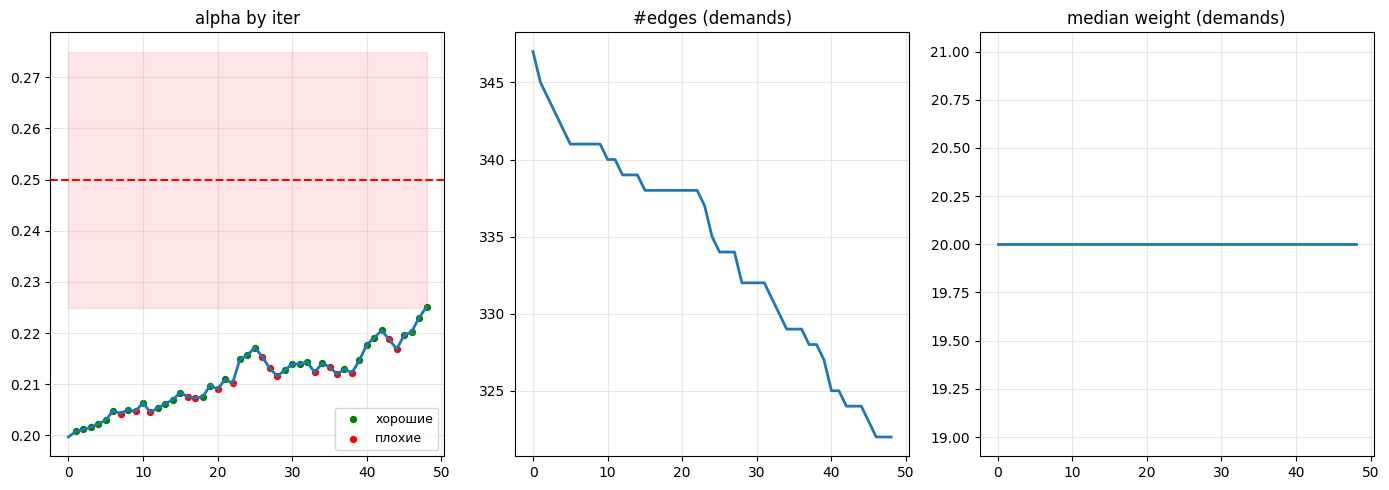

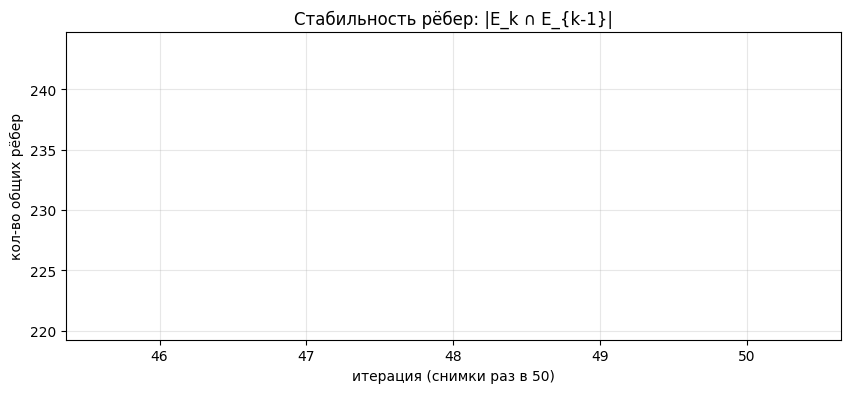

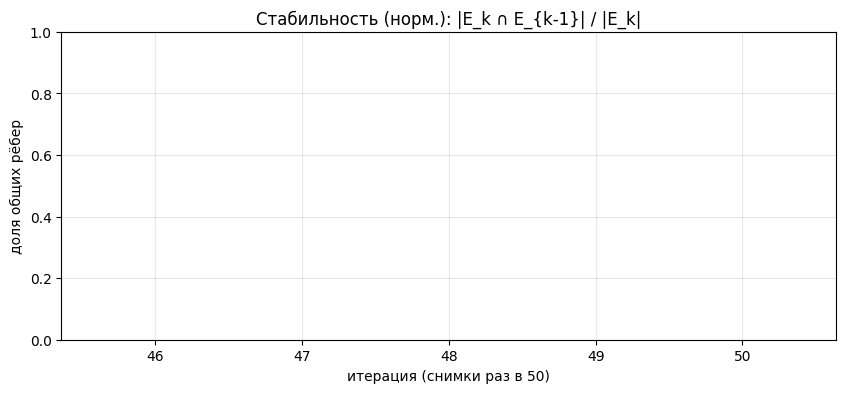

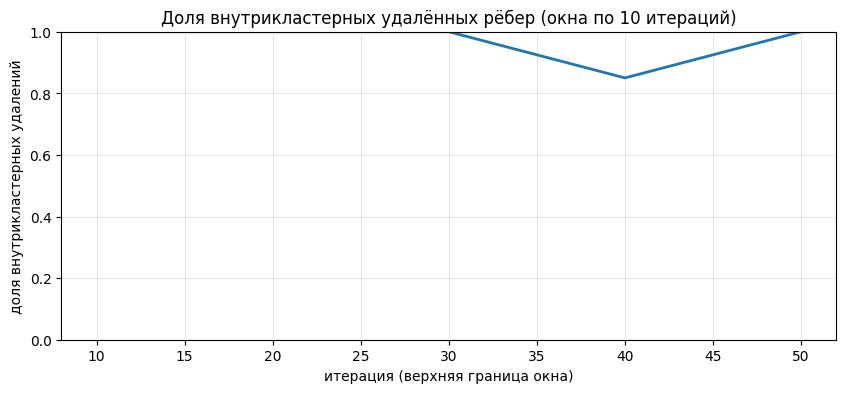

 метрика  initial  final
   edges      347    322
median_w       20     20
  mean_w       20     22
   sum_w     6913   7128


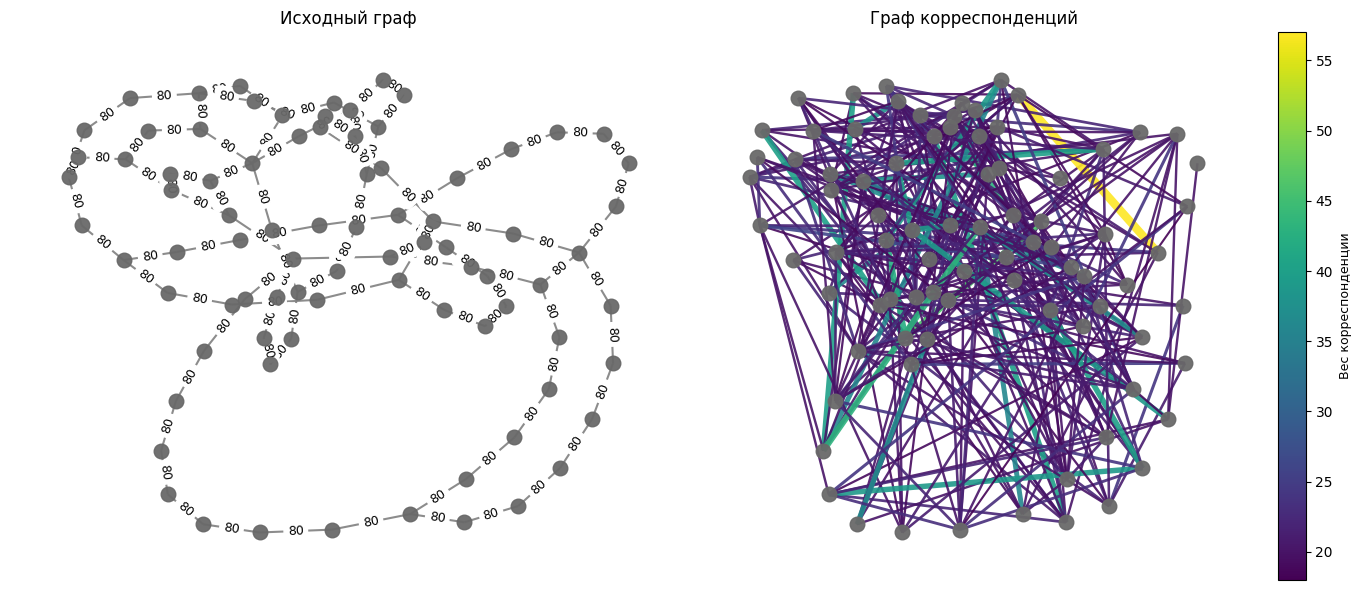

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 11.89 c
Итераций: 2175 (доля от максимума 8300 = 26.20%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.2228, final_alpha=0.4897, converged=True
Плохие шаги всего: 1039 (доля 0.48)
  — adversarial-плохих: 1039 (доля 0.48)
  — friendly-плохих:   0 (доля 0.00)


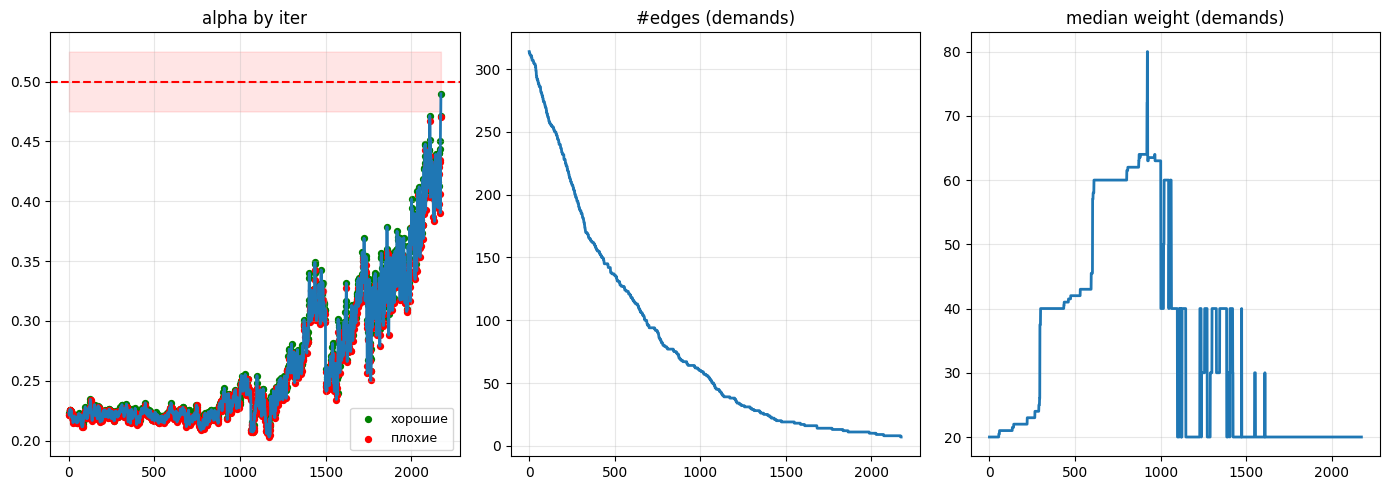

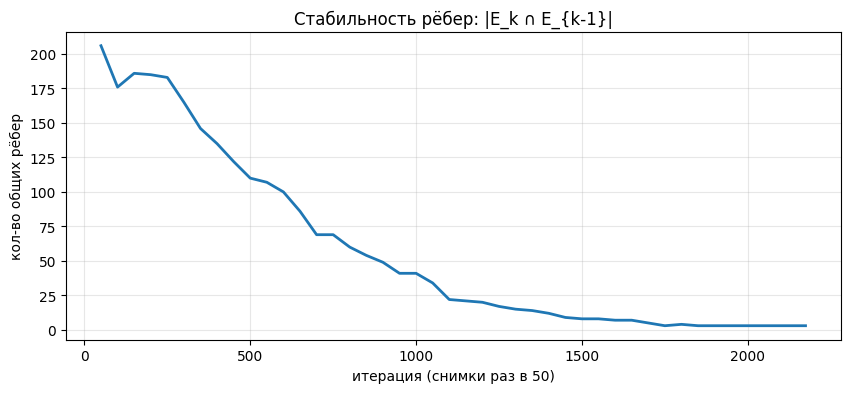

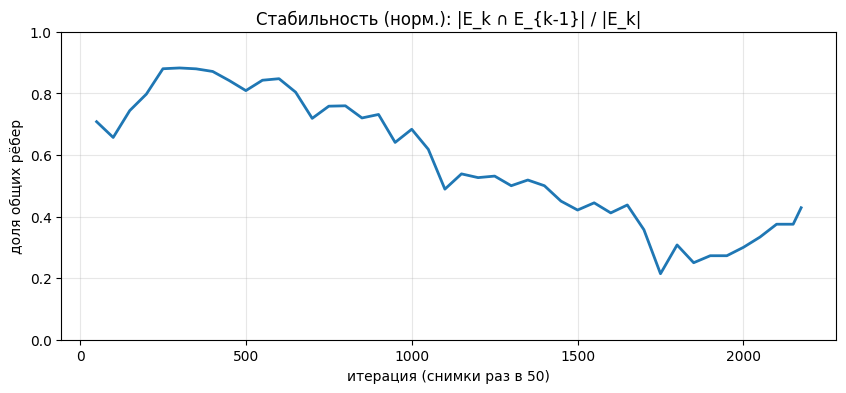

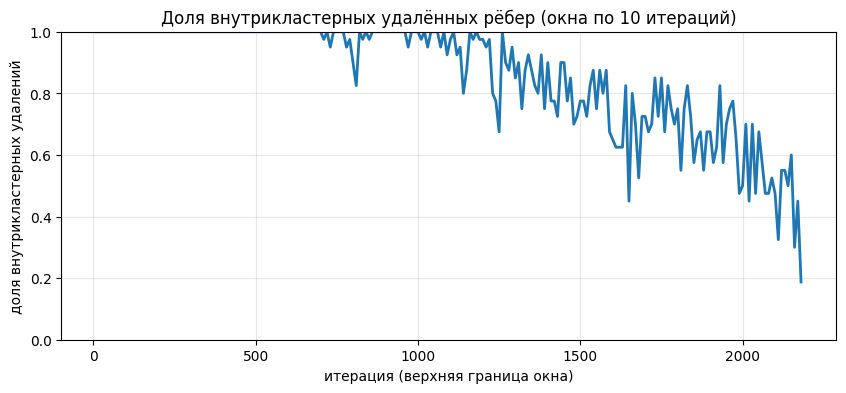

 метрика  initial  final
   edges      314      7
median_w       20     20
  mean_w       20     66
   sum_w     6306    463


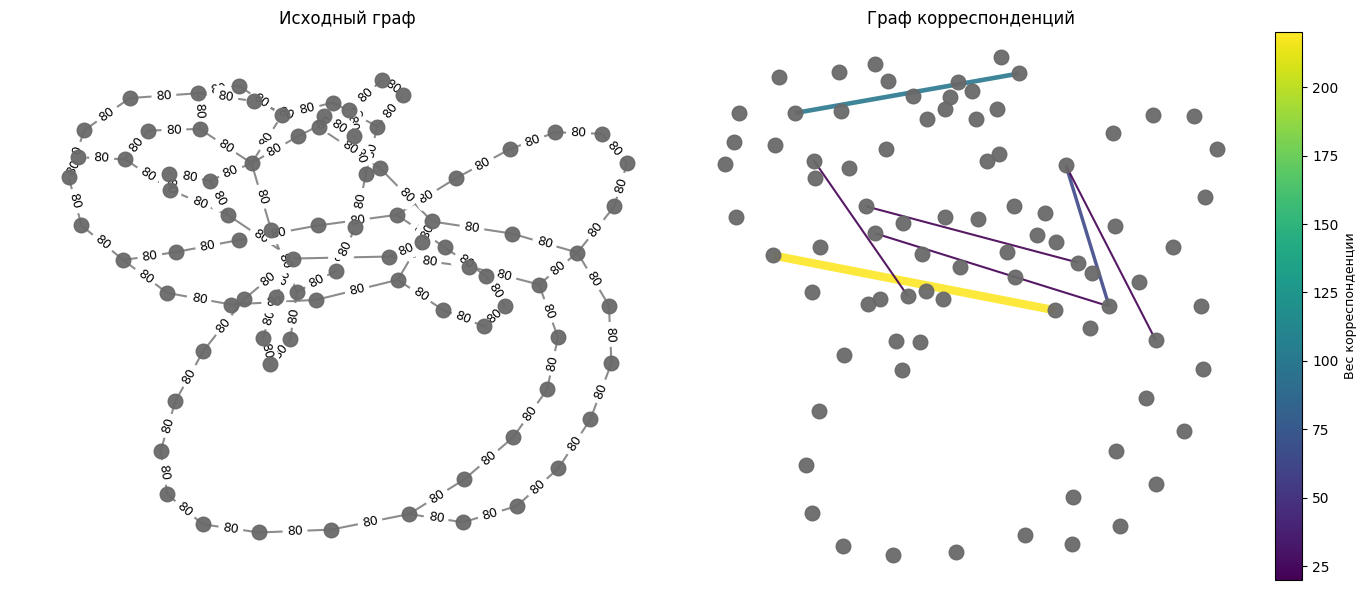

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 10.12 c
Итераций: 2091 (доля от максимума 8300 = 25.19%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.2260, final_alpha=0.7383, converged=True
Плохие шаги всего: 1037 (доля 0.50)
  — adversarial-плохих: 1037 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


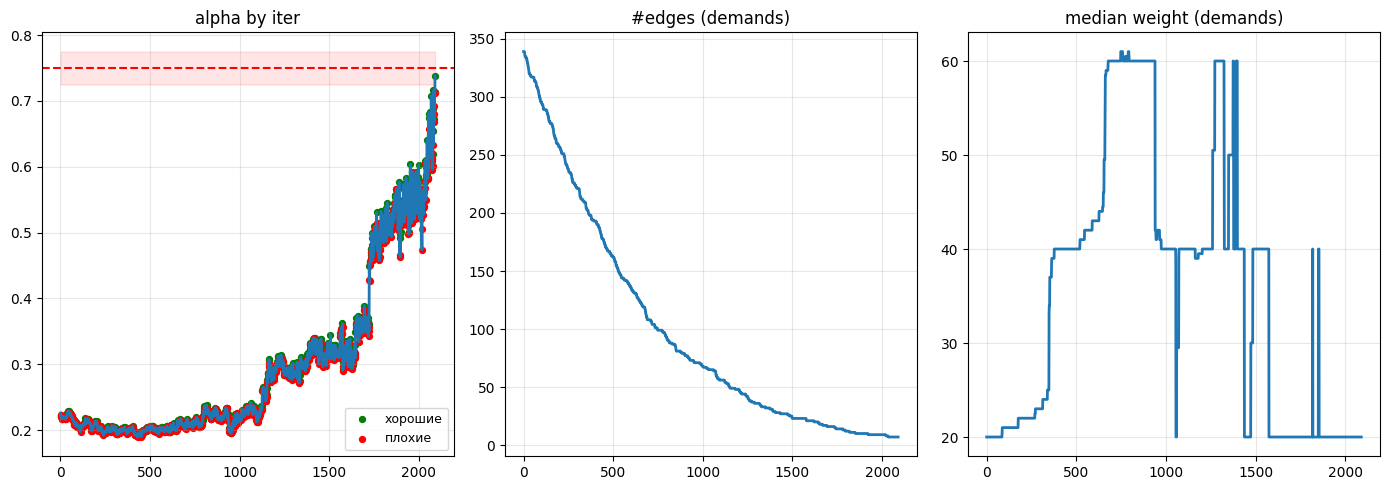

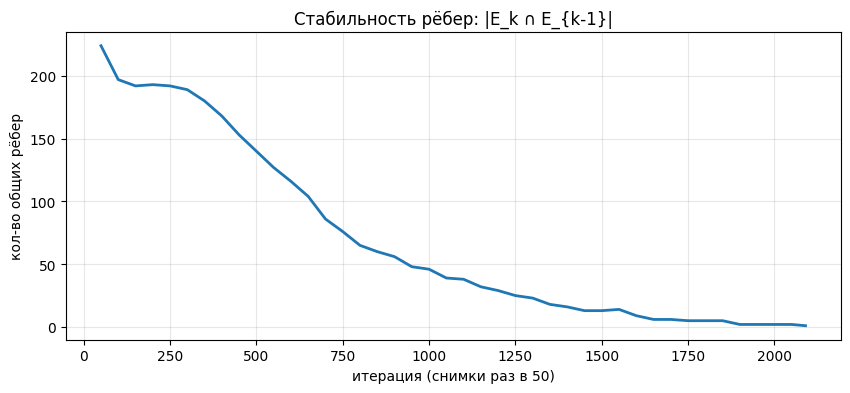

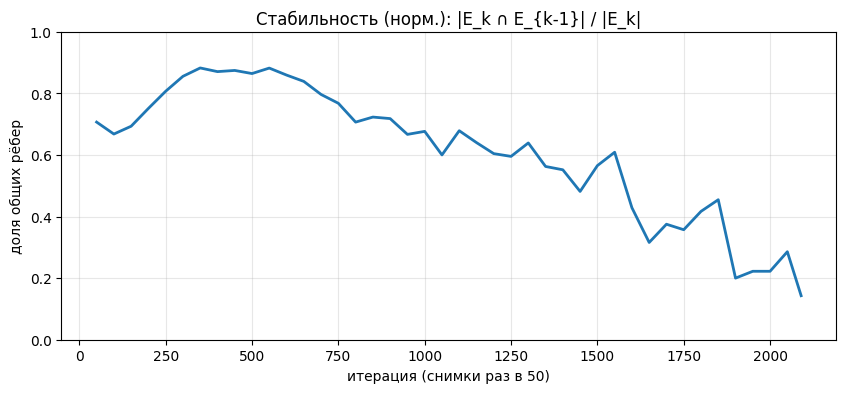

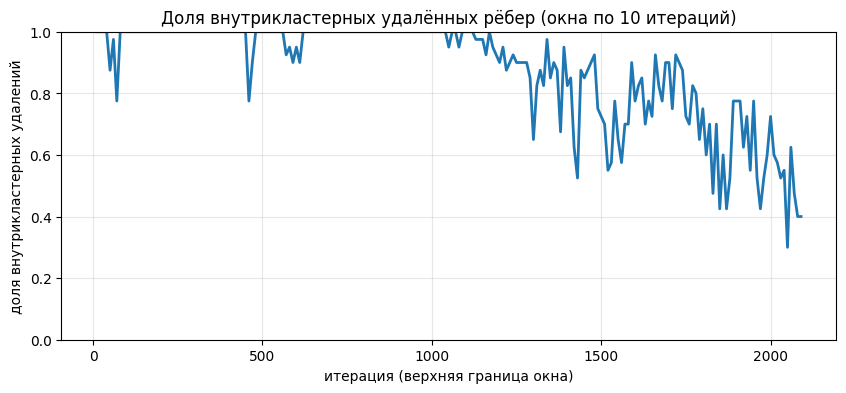

 метрика  initial  final
   edges      339      7
median_w       20     20
  mean_w       20     49
   sum_w     6726    340


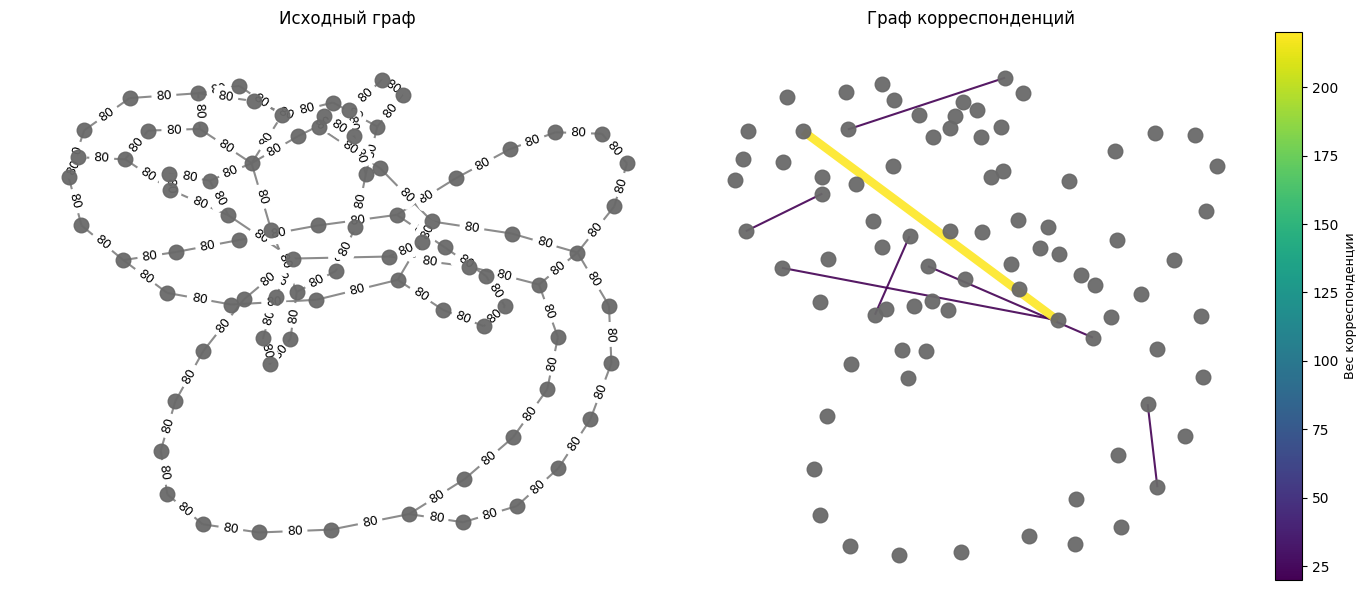



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 0.08320332809888188 alpha_target=0.5: 0.5280528051676743 alpha_target=0.75: 0.6153846153686512


=================================== Конец анализа работы алгоритма для cola_t10 ===================================


====================================   Анализ работы алгоритма для cola_t3  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.15 c
Итераций: 17 (доля от максимума 2100 = 0.81%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.3687, final_alpha=0.2562, converged=True
Плохие шаги всего: 7 (доля 0.44)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   7 (доля 0.44)


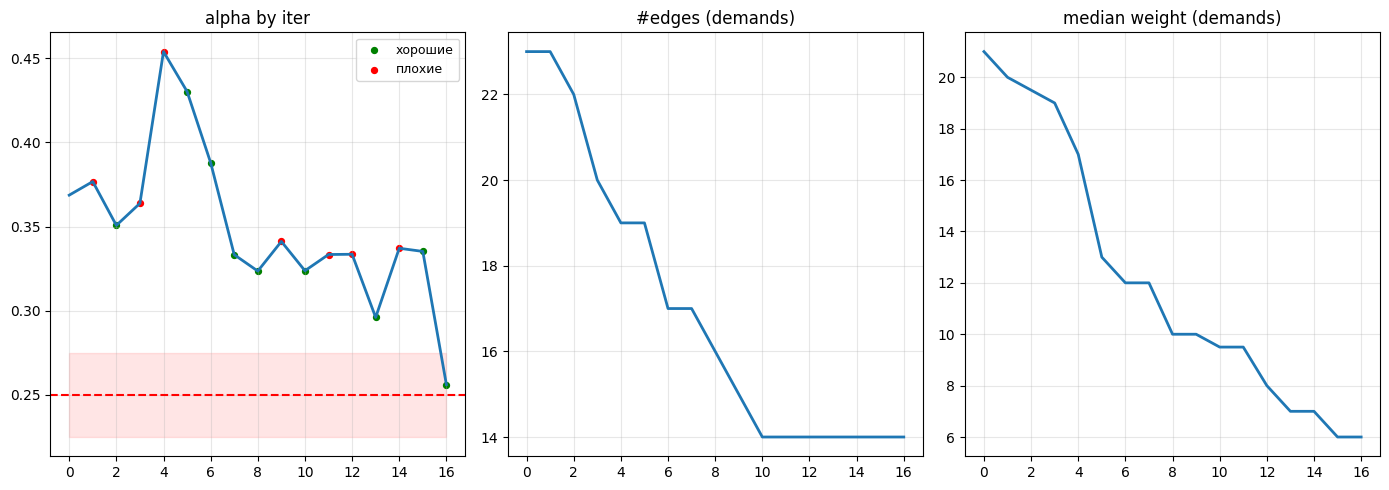

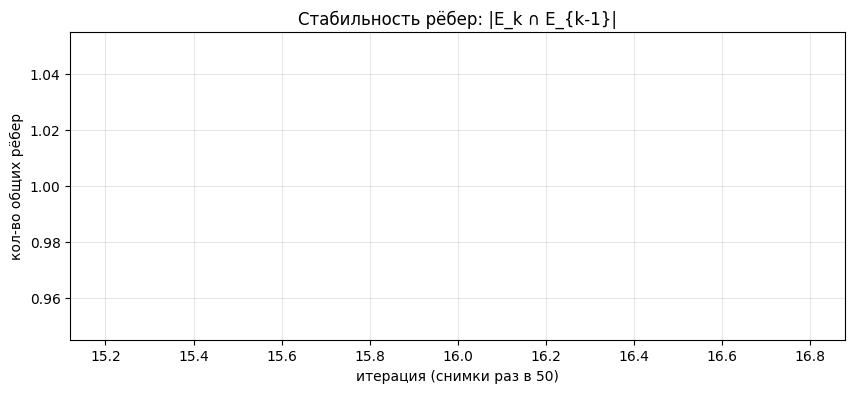

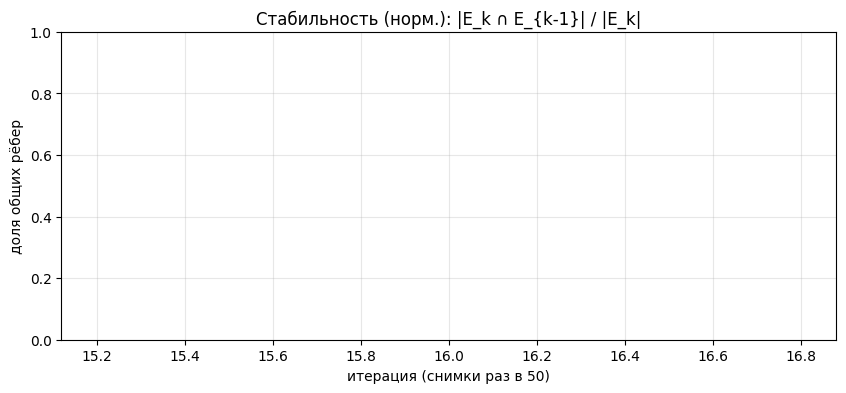

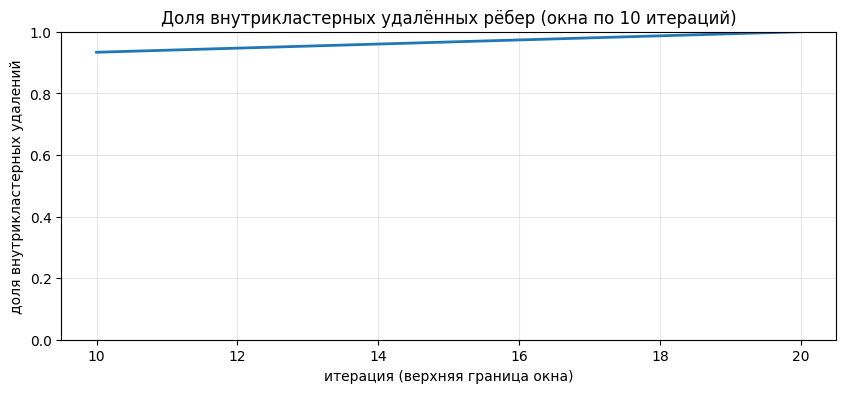

 метрика  initial  final
   edges       23     14
median_w       21      6
  mean_w       20      8
   sum_w      469    109


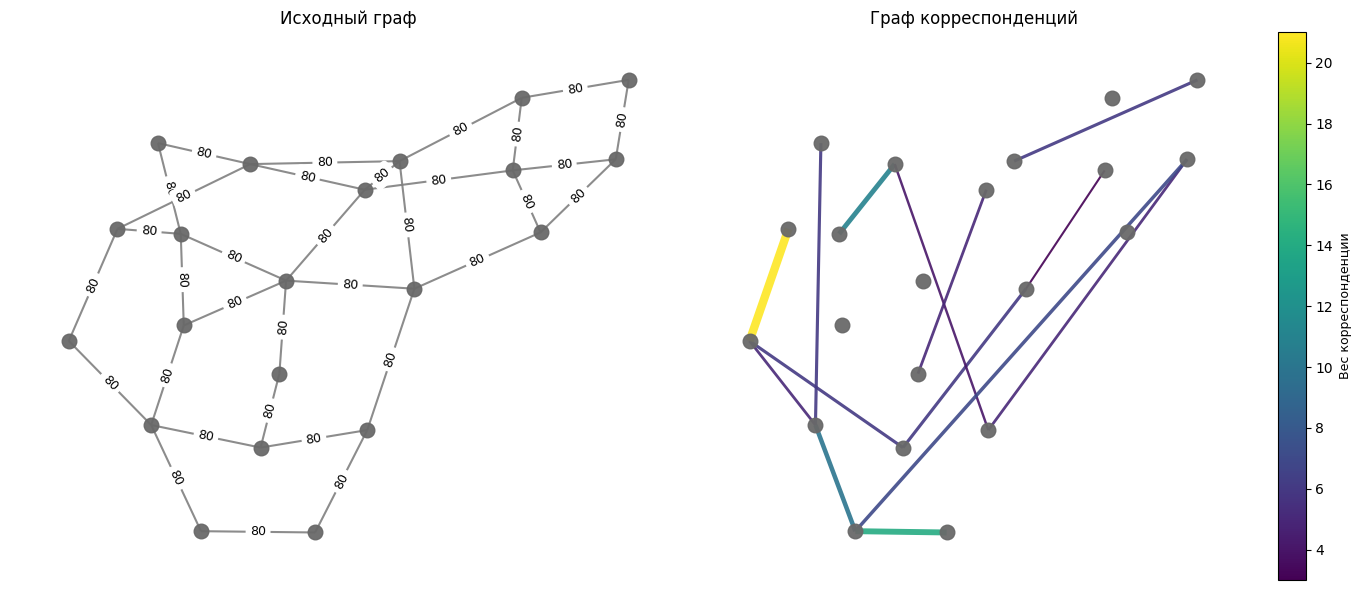

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.13 c
Итераций: 40 (доля от максимума 2100 = 1.90%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.2431, final_alpha=0.4881, converged=True
Плохие шаги всего: 16 (доля 0.41)
  — adversarial-плохих: 16 (доля 0.41)
  — friendly-плохих:   0 (доля 0.00)


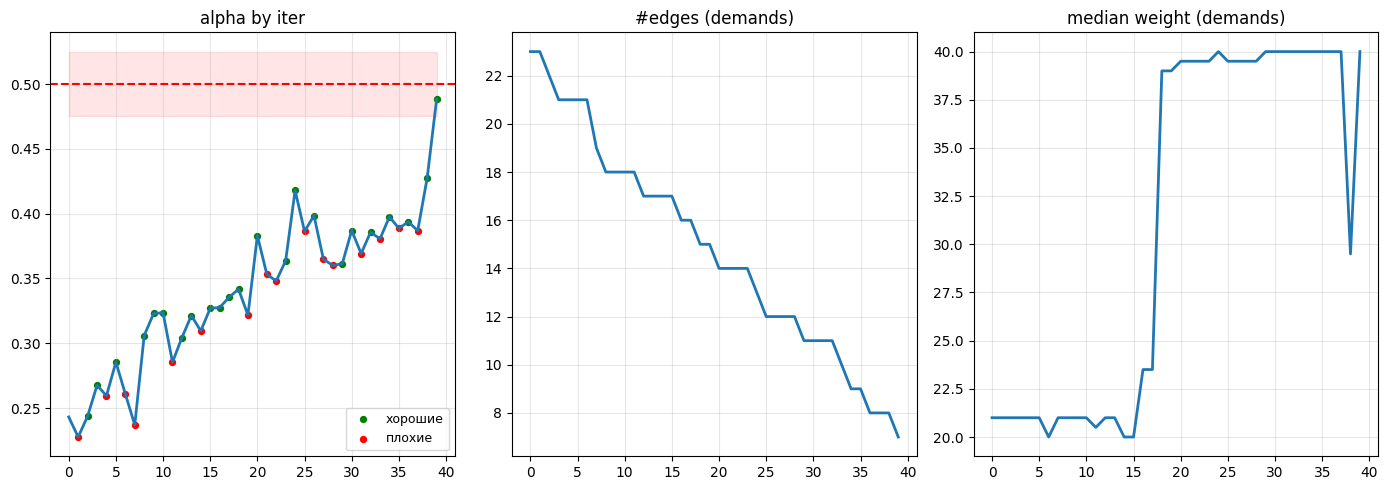

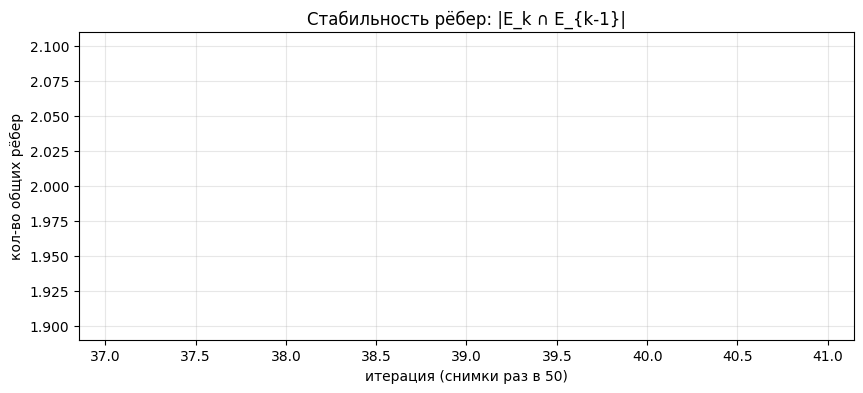

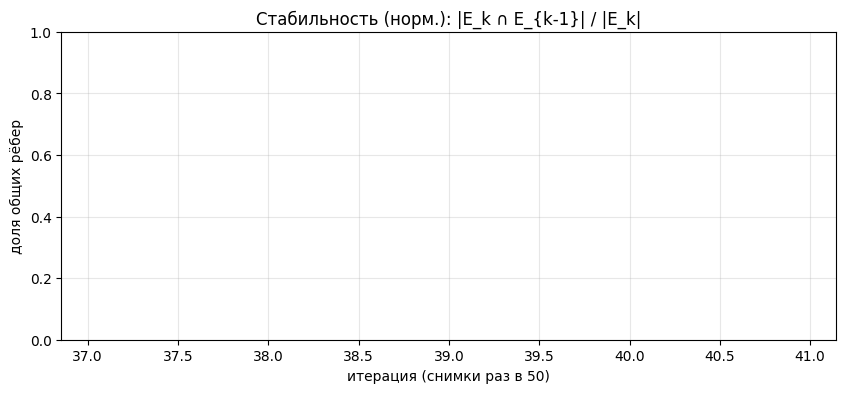

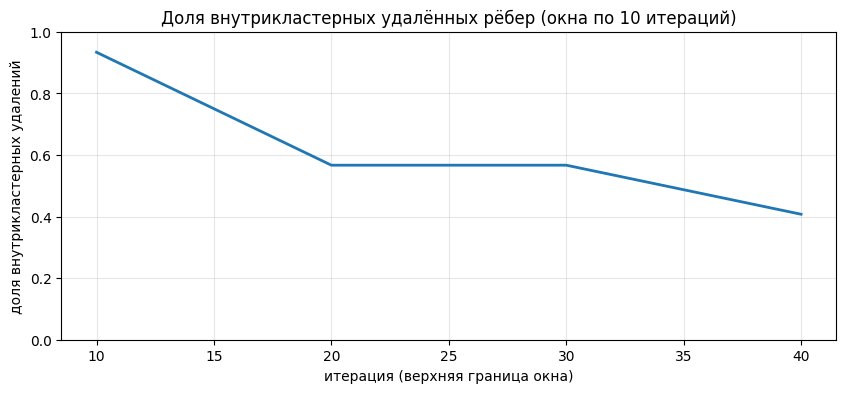

 метрика  initial  final
   edges       23      7
median_w       21     40
  mean_w       20     37
   sum_w      467    260


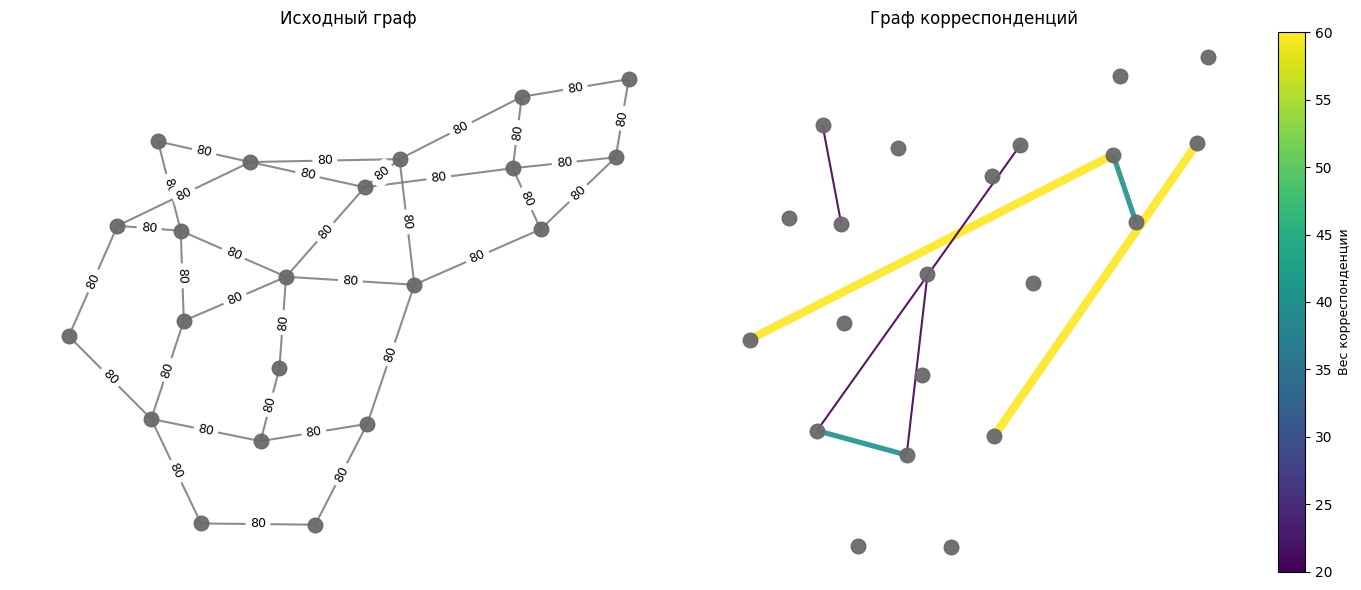

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.22 c
Итераций: 82 (доля от максимума 2100 = 3.90%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.3021, final_alpha=0.7319, converged=True
Плохие шаги всего: 33 (доля 0.41)
  — adversarial-плохих: 33 (доля 0.41)
  — friendly-плохих:   0 (доля 0.00)


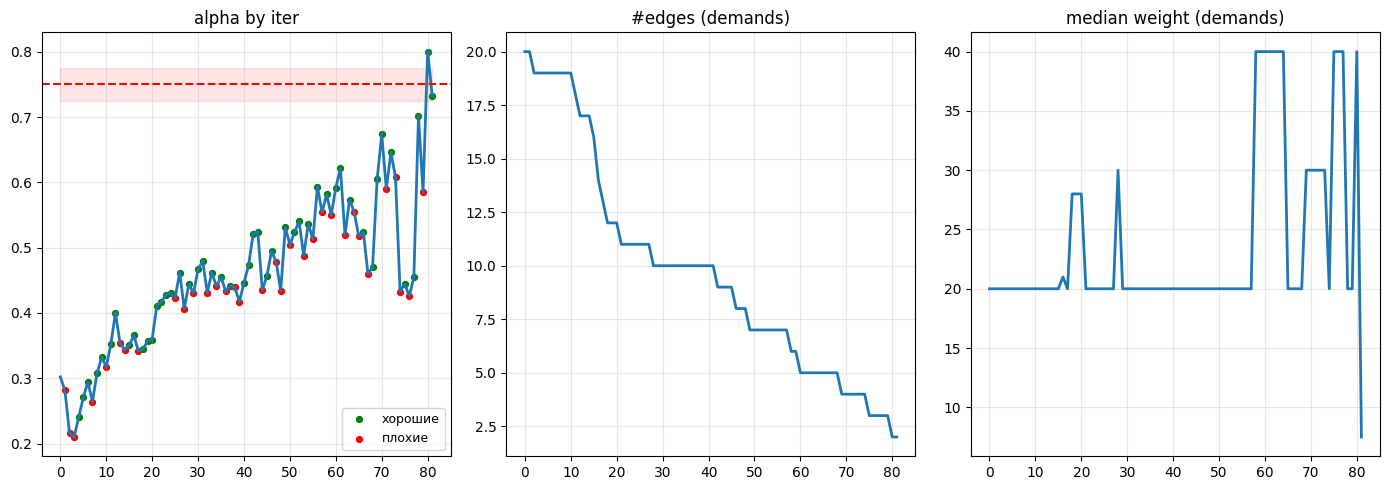

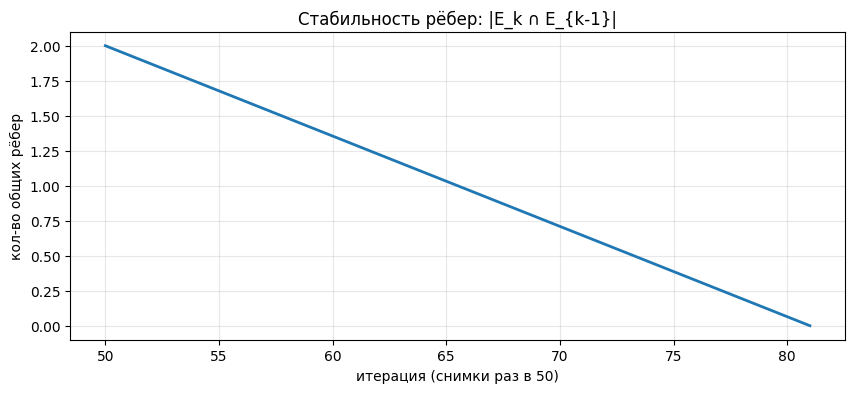

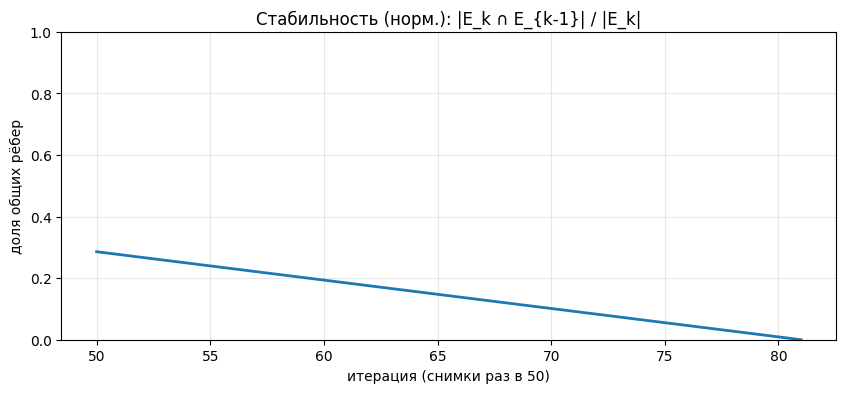

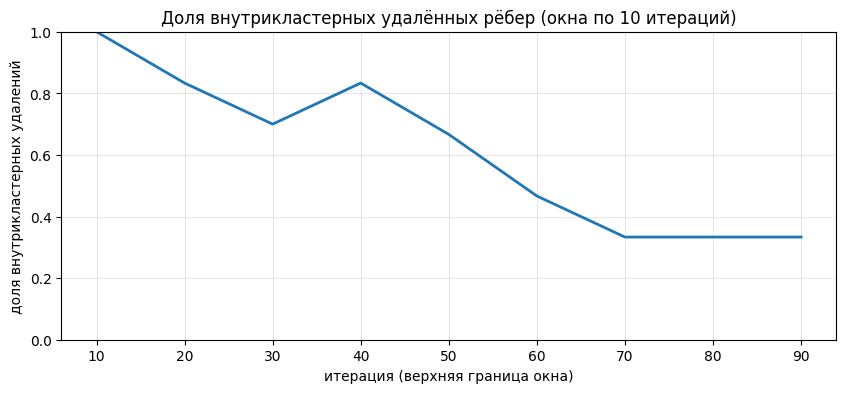

 метрика  initial  final
   edges       20      2
median_w       20      8
  mean_w       20      8
   sum_w      393     15


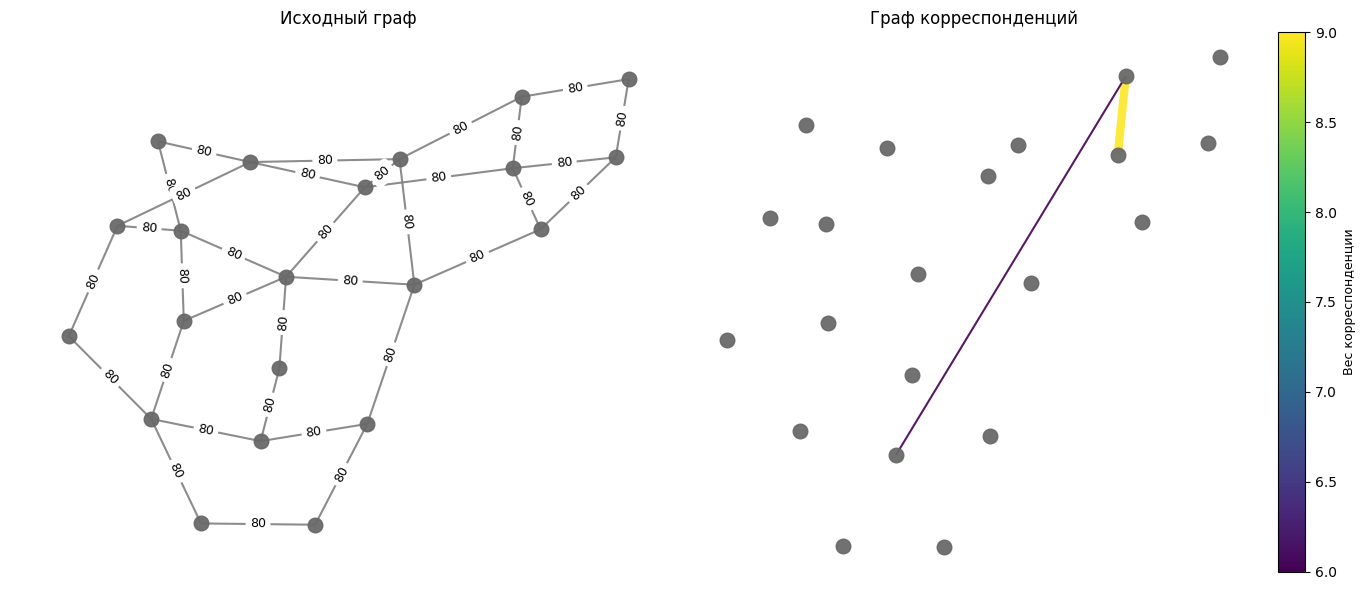



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 4.999999999900707 alpha_target=0.5: 1.9999999979885388 alpha_target=0.75: 15.999999994899445


=================================== Конец анализа работы алгоритма для cola_t3 ===================================


====================================   Анализ работы алгоритма для cola_t8  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 1.78 c
Итераций: 410 (доля от максимума 5400 = 7.59%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.3603, final_alpha=0.2748, converged=True
Плохие шаги всего: 216 (доля 0.53)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   216 (доля 0.53)


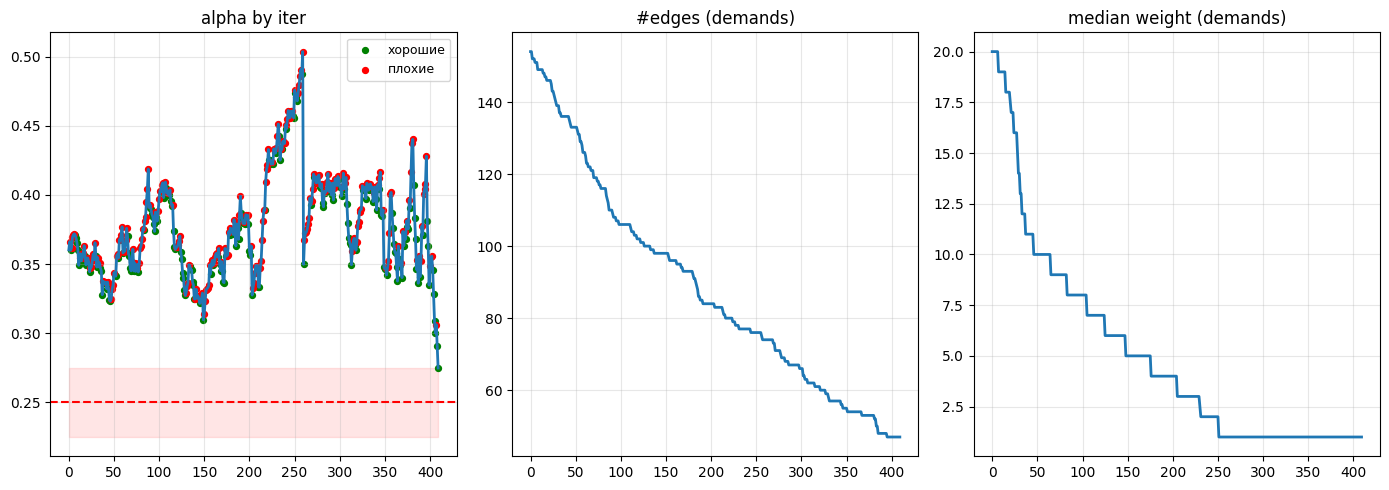

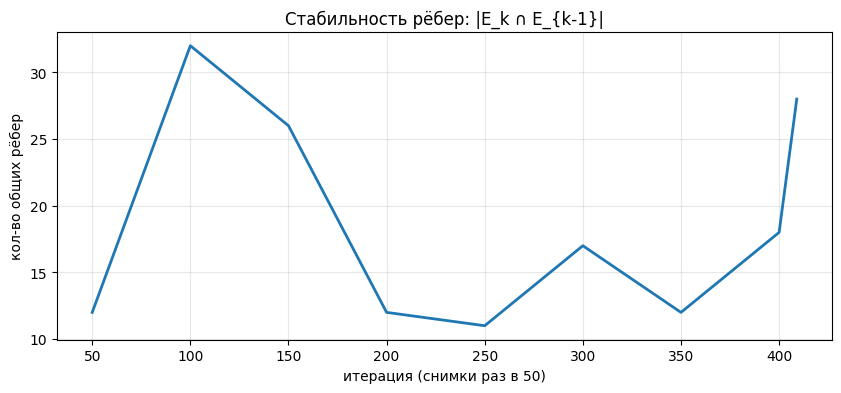

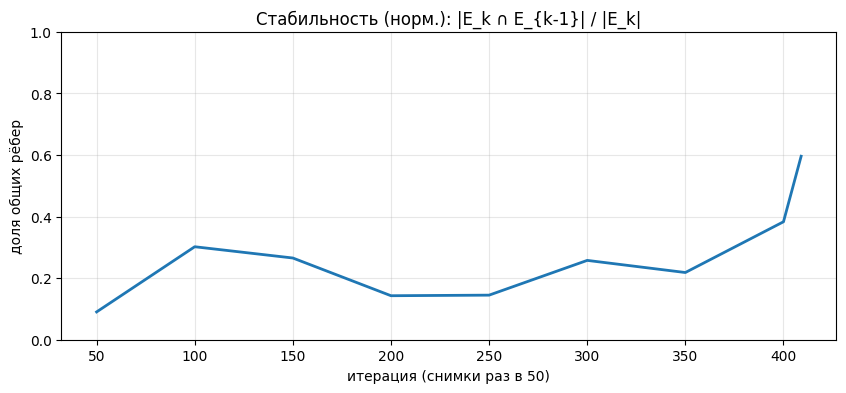

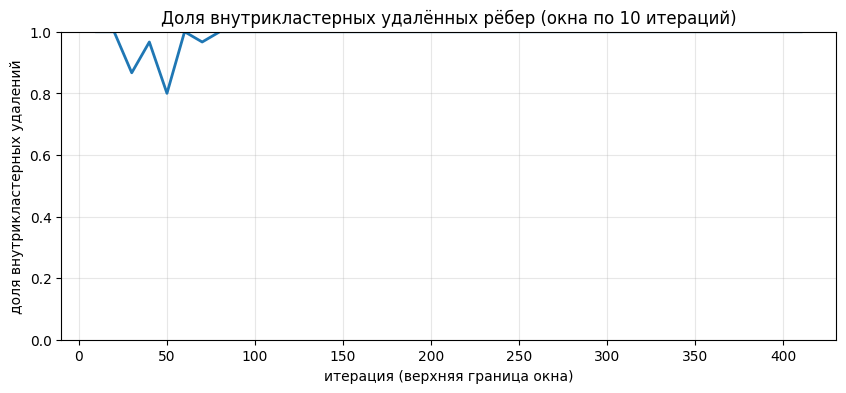

 метрика  initial  final
   edges      154     47
median_w       20      1
  mean_w       20      1
   sum_w     3087     53


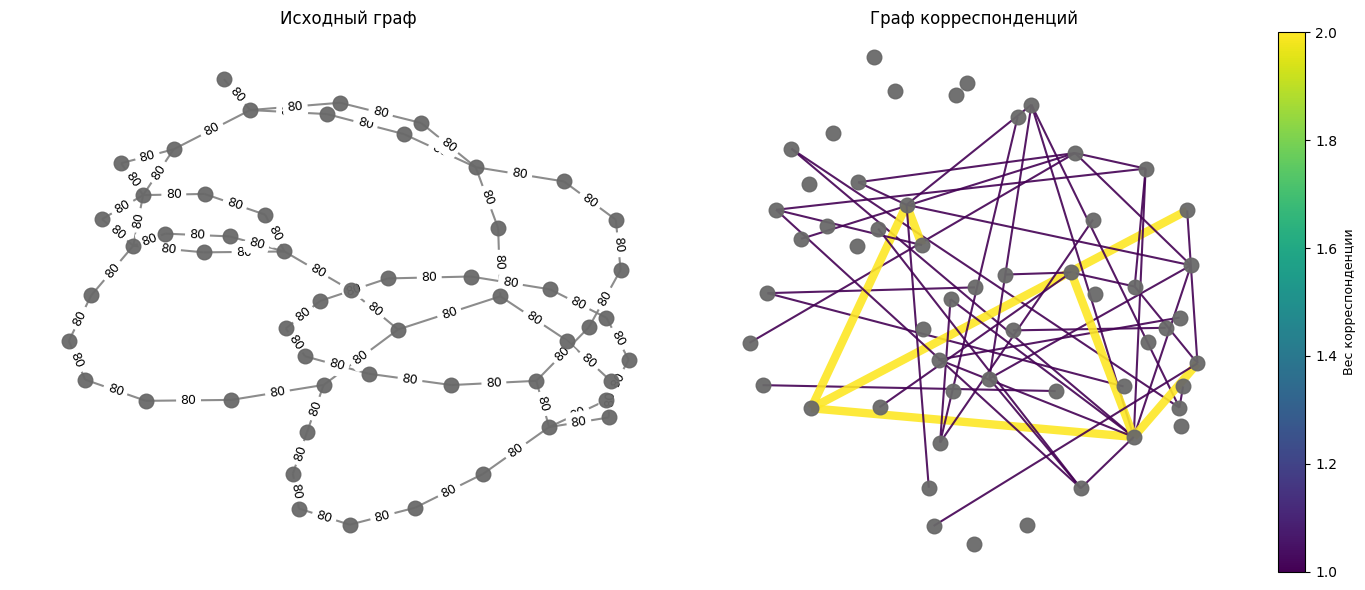

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 6.09 c
Итераций: 878 (доля от максимума 5400 = 16.26%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.3352, final_alpha=0.4819, converged=True
Плохие шаги всего: 441 (доля 0.50)
  — adversarial-плохих: 441 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


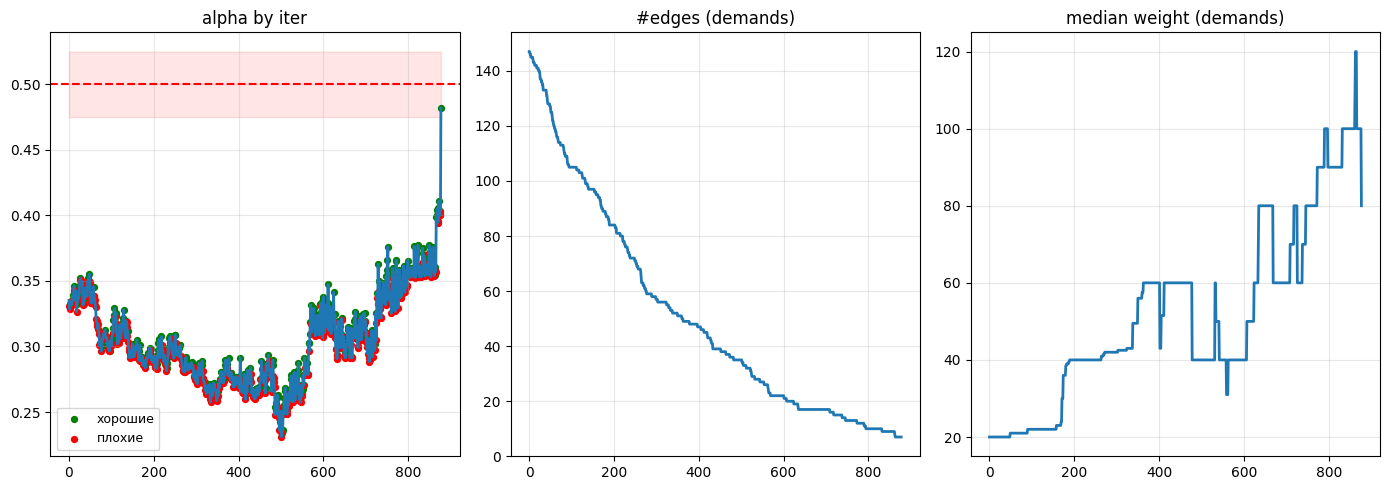

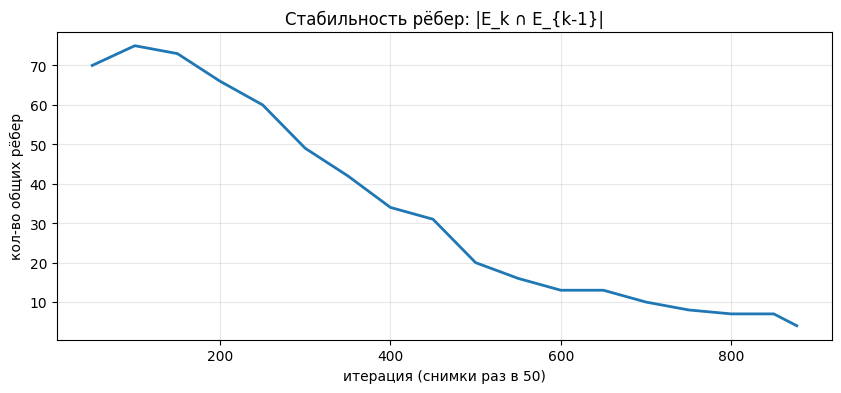

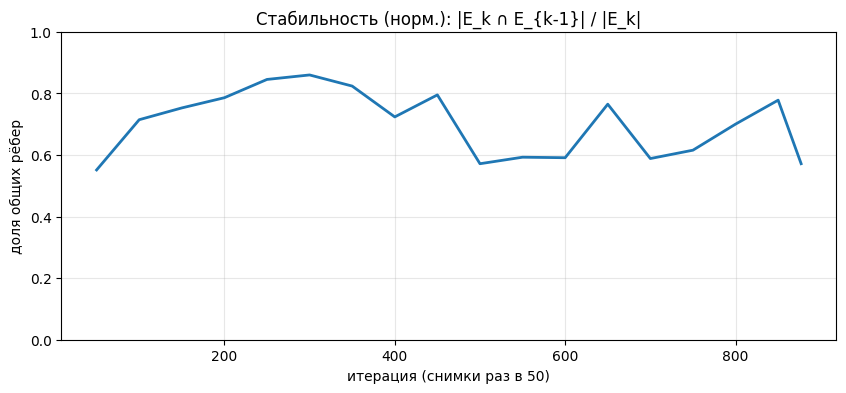

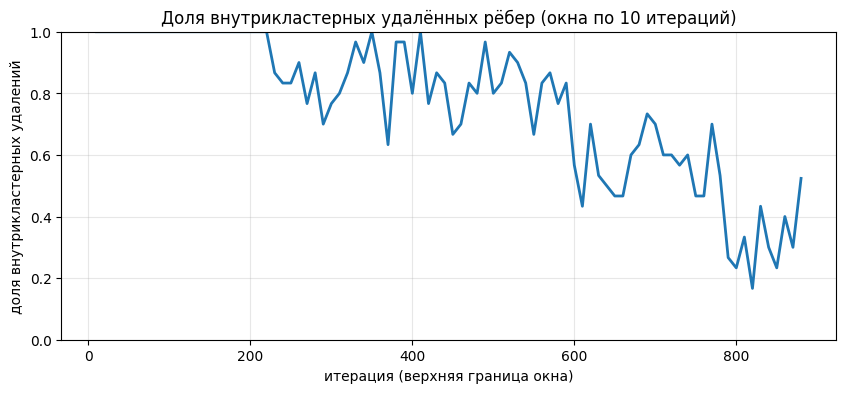

 метрика  initial  final
   edges      147      7
median_w       20     80
  mean_w       20     74
   sum_w     2904    520


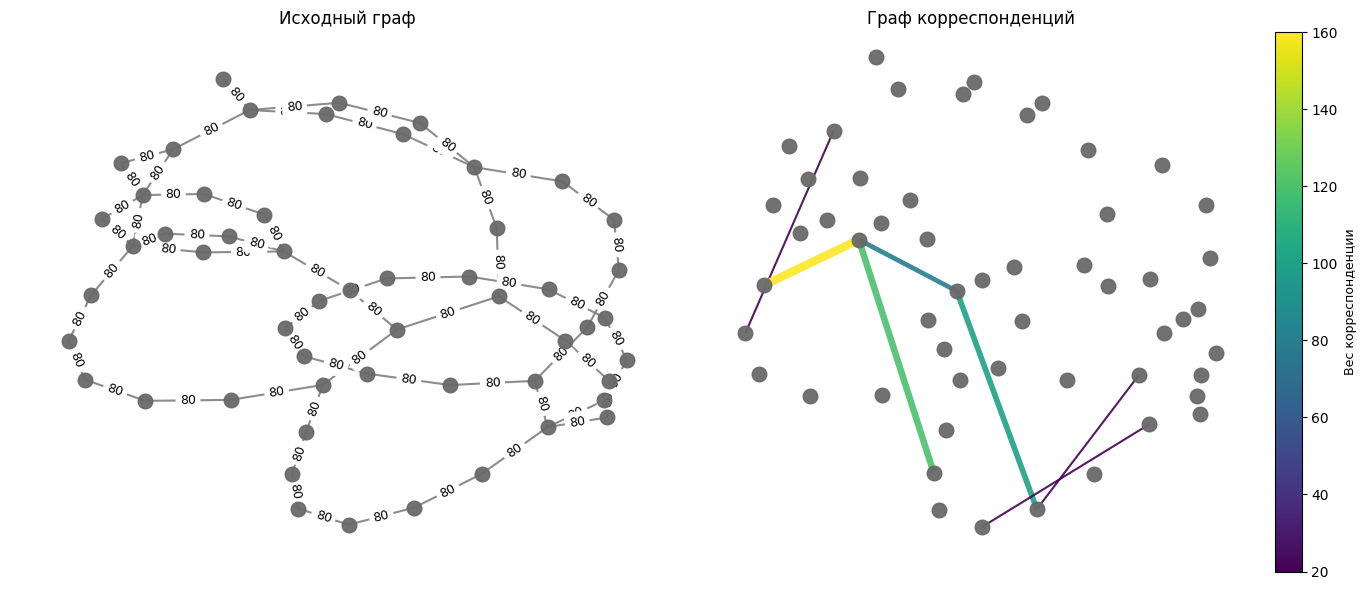

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 3.98 c
Итераций: 1066 (доля от максимума 5400 = 19.74%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.3699, final_alpha=0.7544, converged=True
Плохие шаги всего: 540 (доля 0.51)
  — adversarial-плохих: 540 (доля 0.51)
  — friendly-плохих:   0 (доля 0.00)


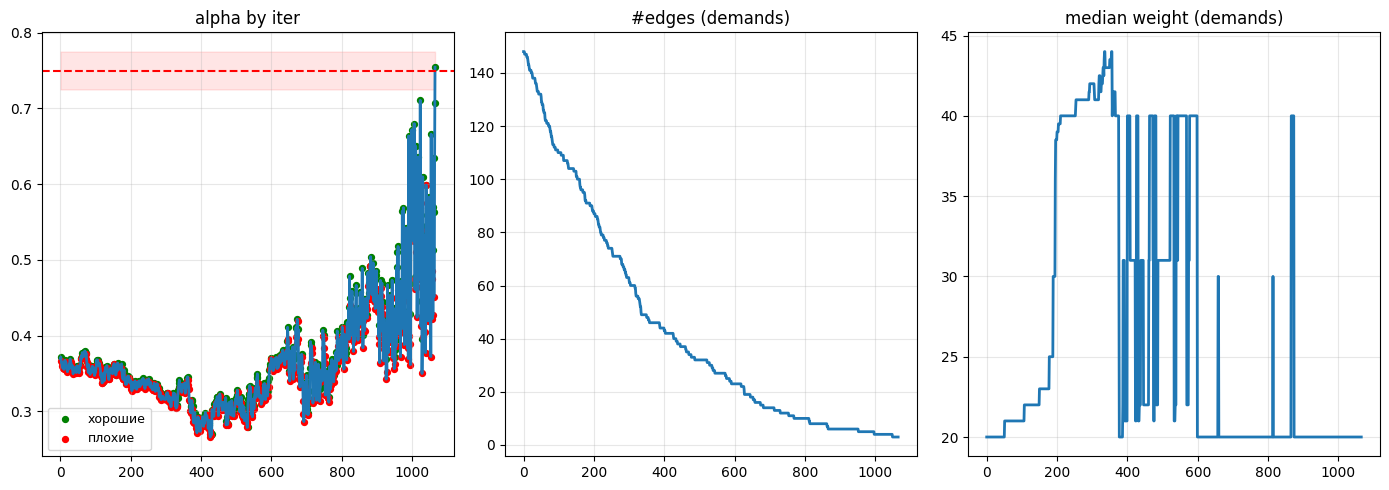

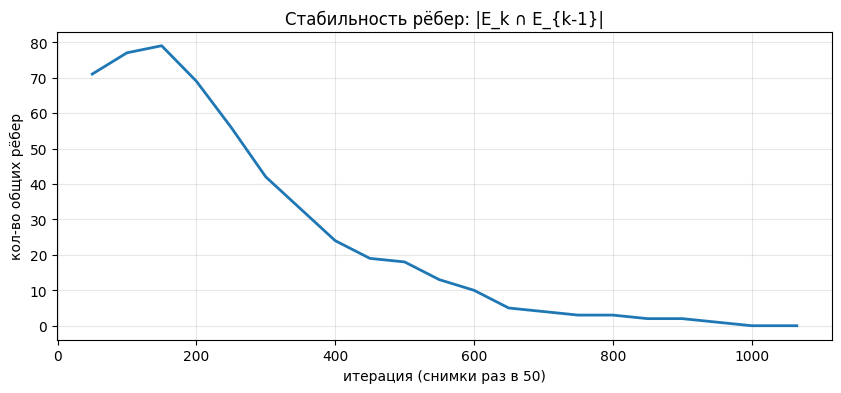

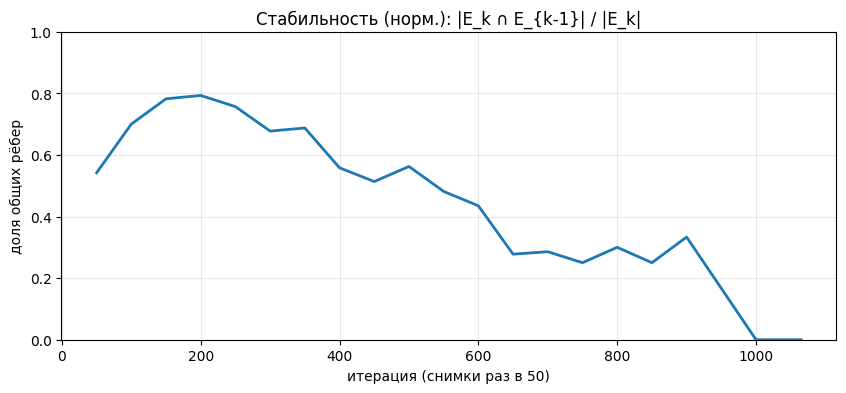

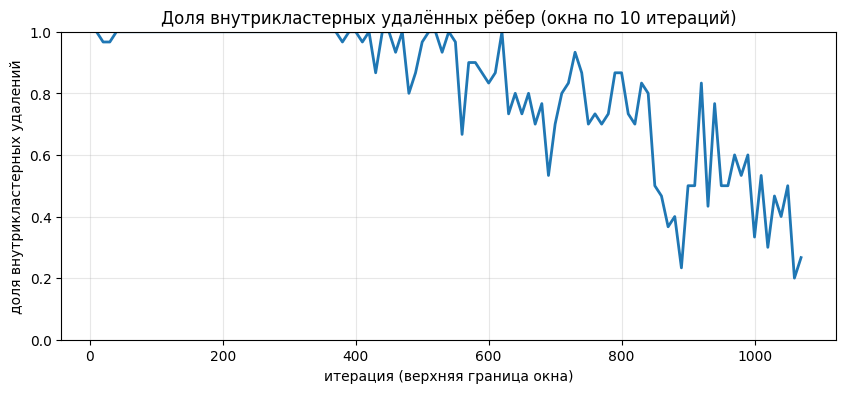

 метрика  initial  final
   edges      148      3
median_w       20     20
  mean_w       20     20
   sum_w     2941     60


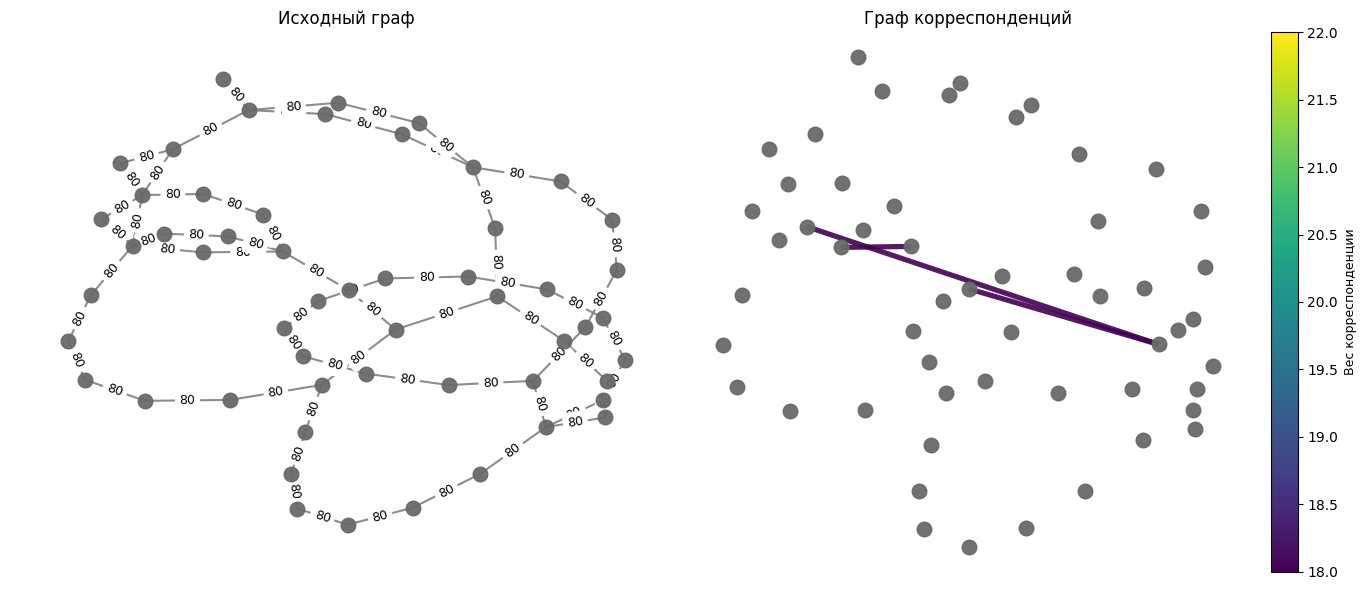



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 8.888888882985306 alpha_target=0.5: 0.4444444439781254 alpha_target=0.75: 3.9999999995473297


=================================== Конец анализа работы алгоритма для cola_t8 ===================================


====================================   Анализ работы алгоритма для cola_t2  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.08 c
Итераций: 26 (доля от максимума 3200 = 0.81%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.1964, final_alpha=0.2400, converged=True
Плохие шаги всего: 12 (доля 0.48)
  — adversarial-плохих: 12 (доля 0.48)
  — friendly-плохих:   0 (доля 0.00)


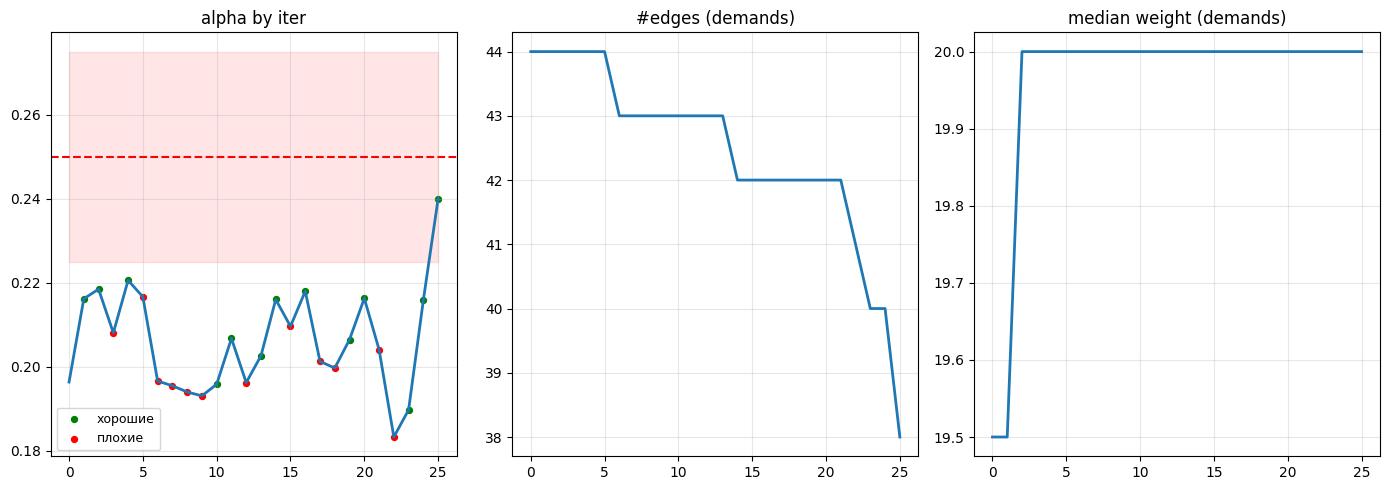

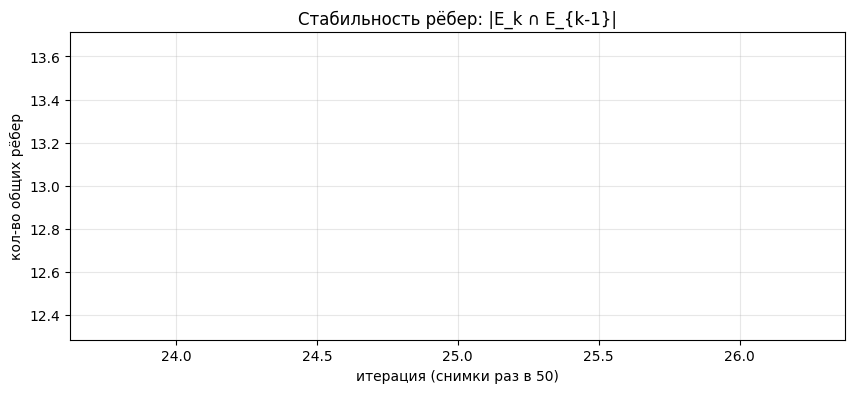

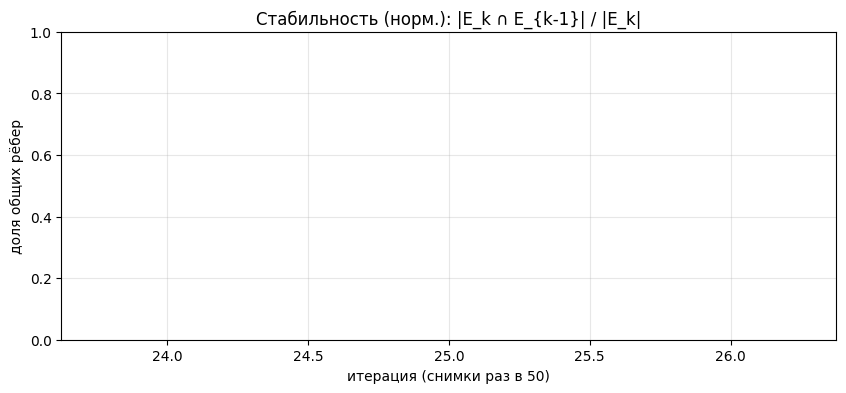

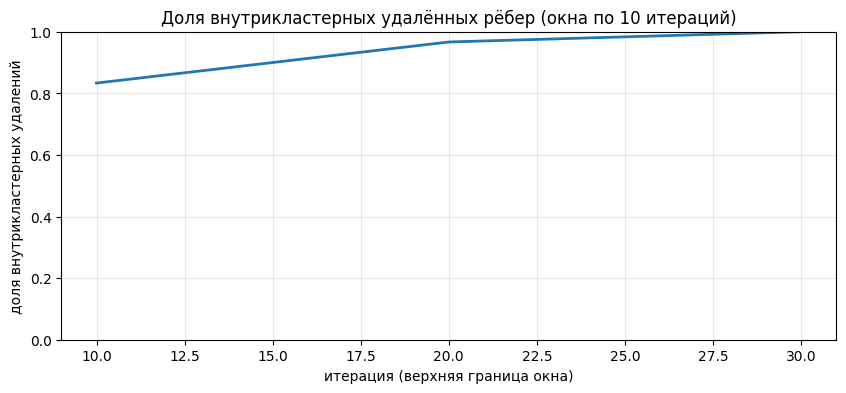

 метрика  initial  final
   edges       44     38
median_w       20     20
  mean_w       20     24
   sum_w      863    903


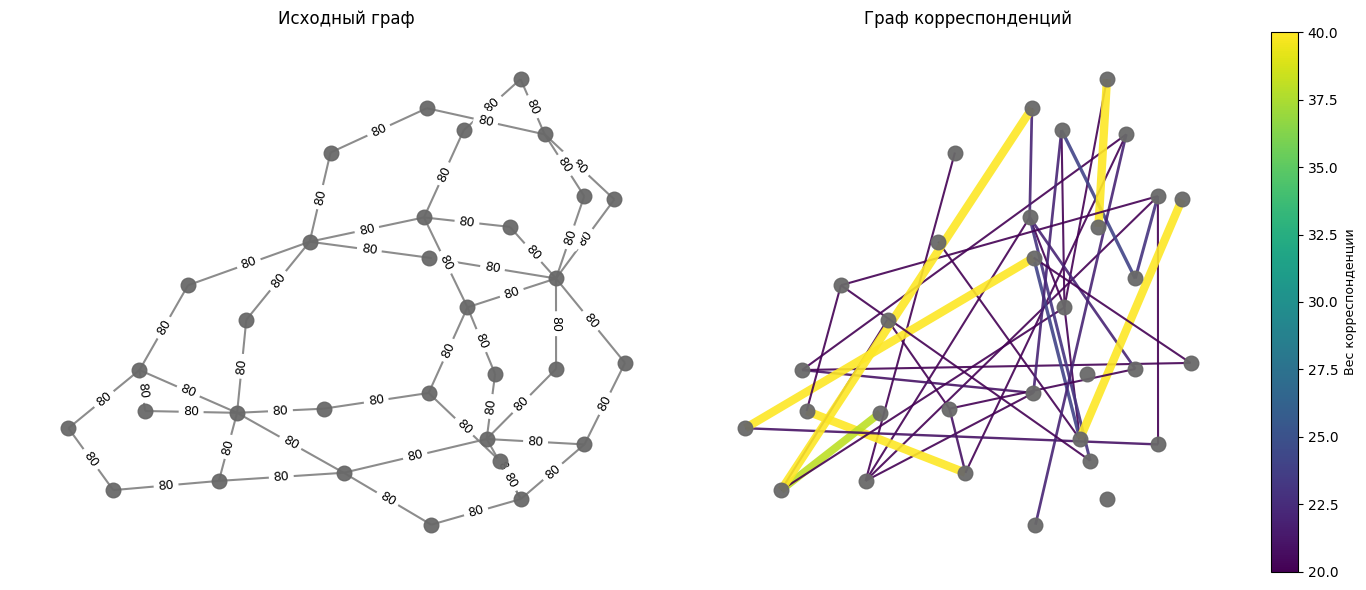

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.42 c
Итераций: 203 (доля от максимума 3200 = 6.34%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.2299, final_alpha=0.4796, converged=True
Плохие шаги всего: 89 (доля 0.44)
  — adversarial-плохих: 89 (доля 0.44)
  — friendly-плохих:   0 (доля 0.00)


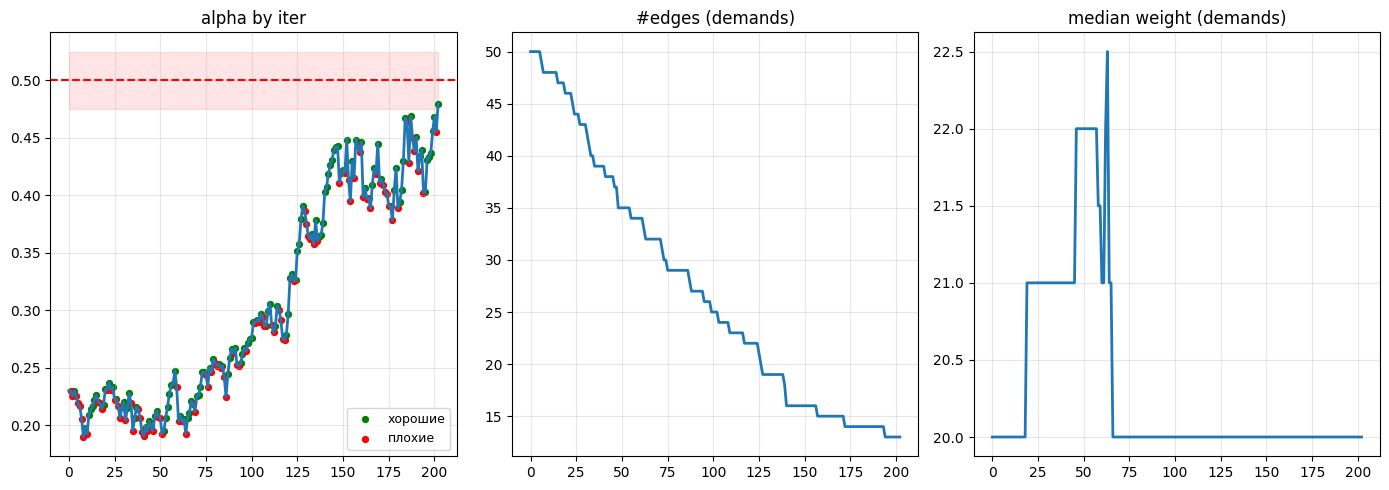

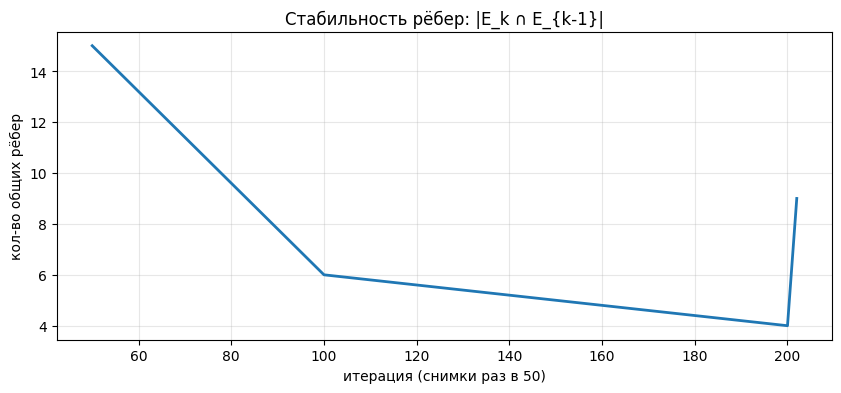

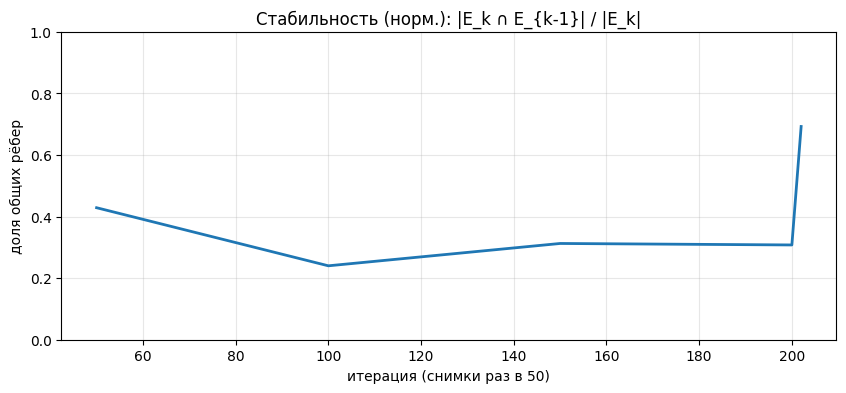

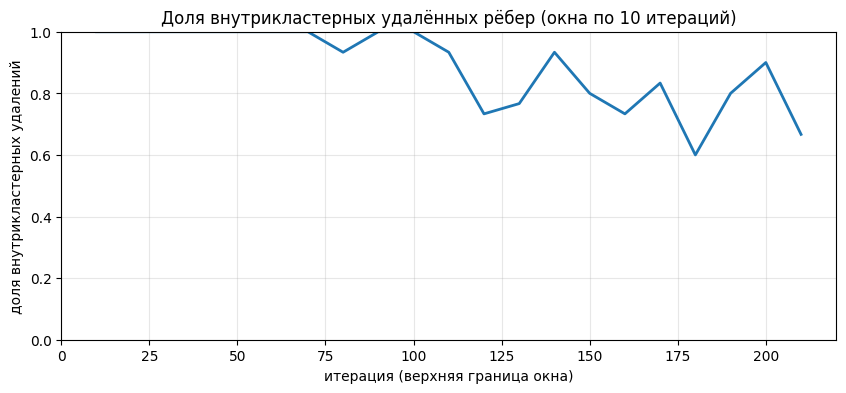

 метрика  initial  final
   edges       50     13
median_w       20     20
  mean_w       20     31
   sum_w     1005    399


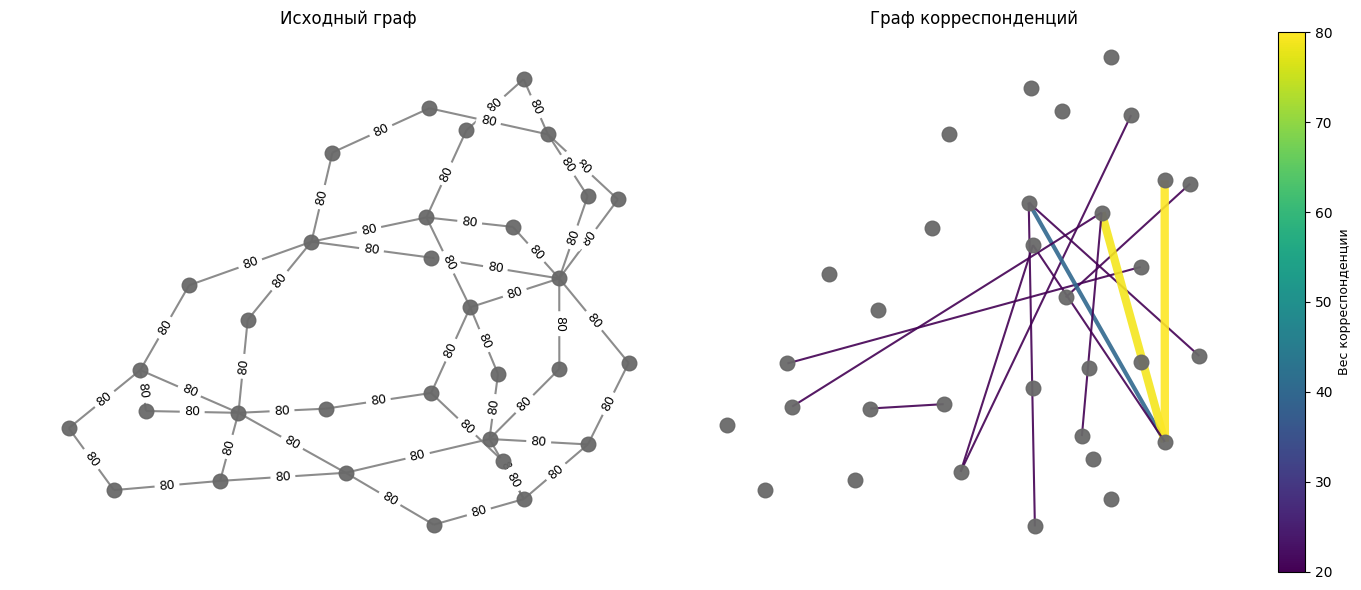

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 1.18 c
Итераций: 413 (доля от максимума 3200 = 12.91%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.2018, final_alpha=0.7367, converged=True
Плохие шаги всего: 189 (доля 0.46)
  — adversarial-плохих: 189 (доля 0.46)
  — friendly-плохих:   0 (доля 0.00)


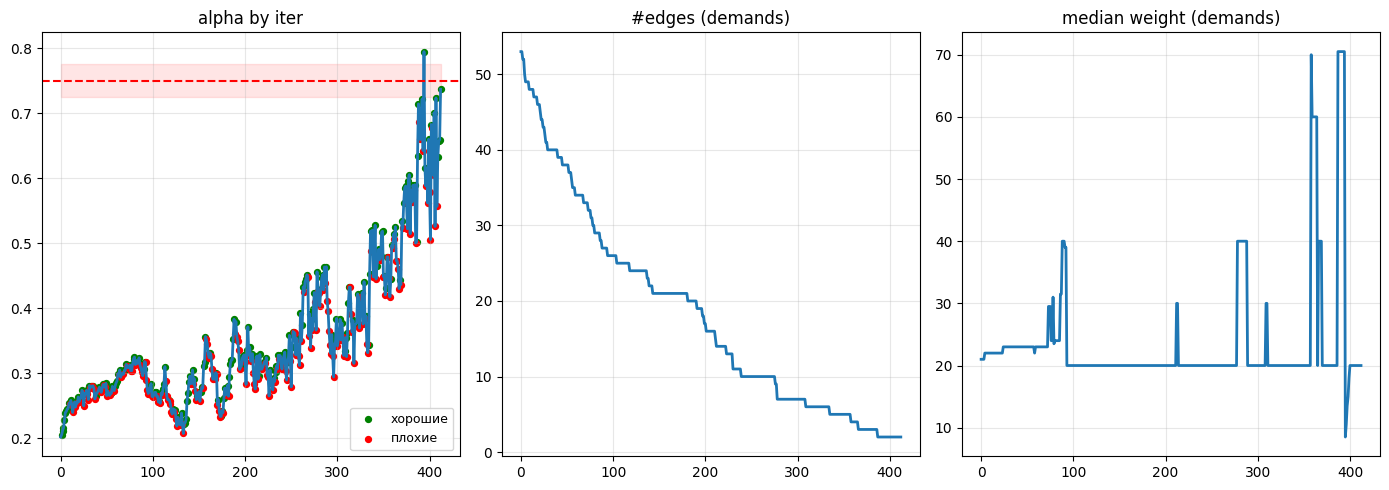

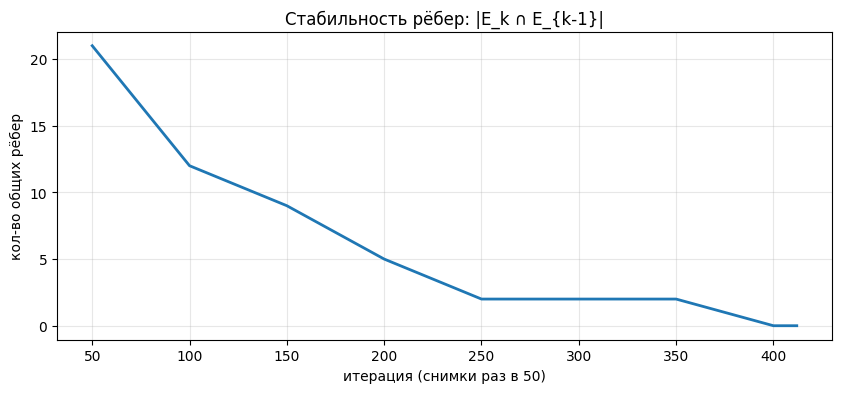

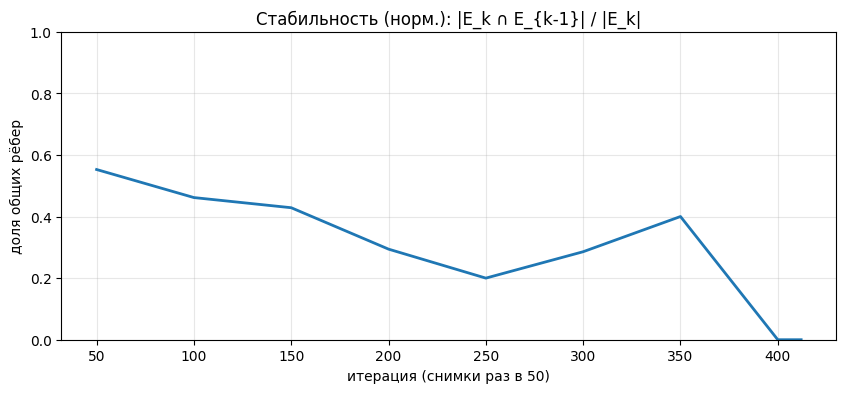

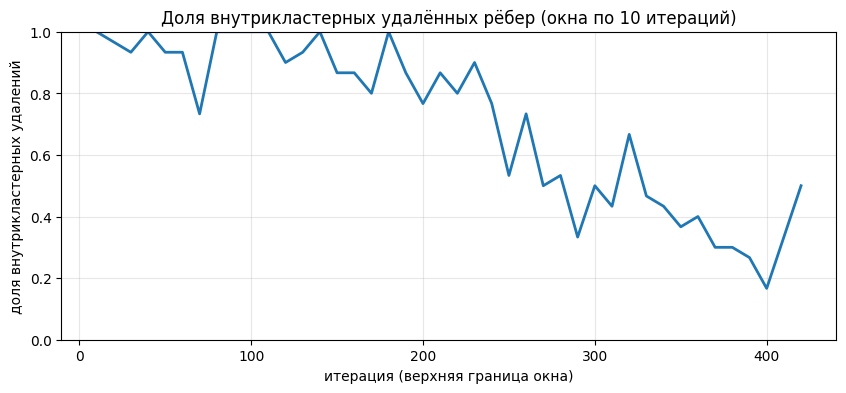

 метрика  initial  final
   edges       53      2
median_w       21     20
  mean_w       21     20
   sum_w     1099     40


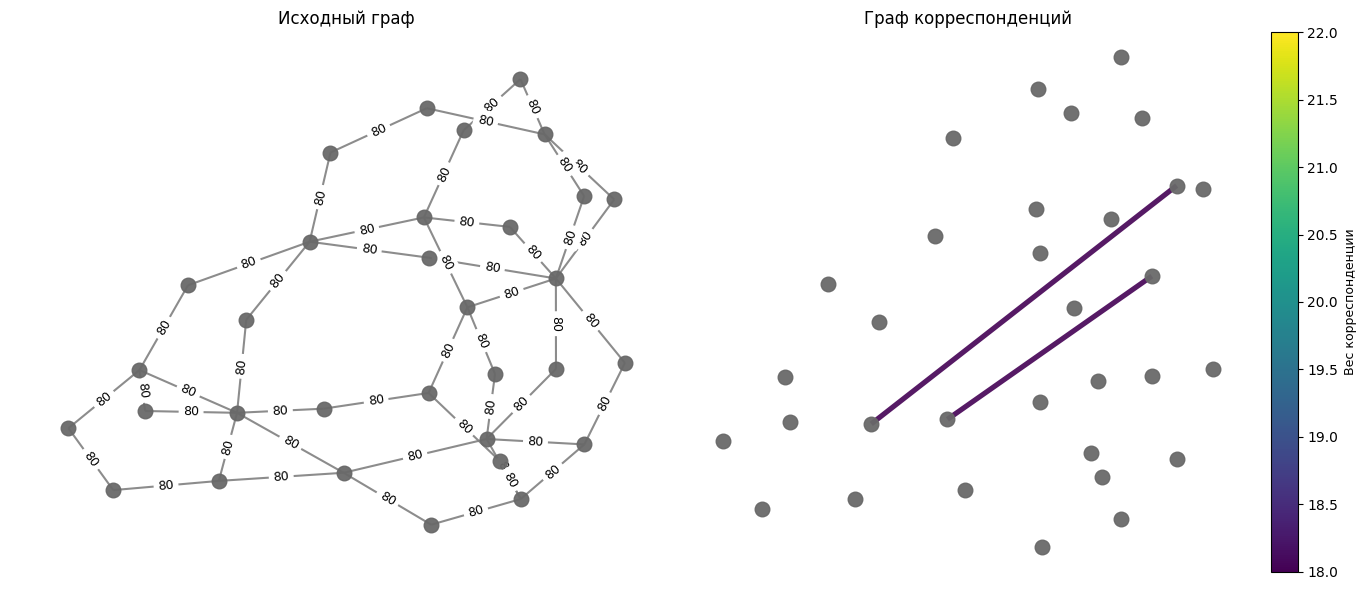



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 0.8142493638462064 alpha_target=0.5: 1.0041841003793874 alpha_target=0.75: 7.999999999852903


=================================== Конец анализа работы алгоритма для cola_t2 ===================================




In [47]:
import numpy as np
from graphmcf import GraphMCF
from graphmcf.demands import MCFGeneratorMultiEdges
from graphmcf.analysis import analyze_simple

alphas_batch = [0.25, 0.5, 0.75] # должна быть хорошая, средняя, плохая проходимость, gamma убывает

for name, graph in small_graphs_for_test.items():
  alphas_gamma = []
  print(f"====================================   Анализ работы алгоритма для {name}  ====================================")
  for alpha_target in alphas_batch:
    graph_for_mcf = GraphMCF(graph['adj_matrix'])
    gen = MCFGeneratorMultiEdges(epsilon=0.025,
                                 p_ER = 0.10, distribution="normal", median_weight_for_initial=20, var_for_initial=5,
                                 demands_median_denominator=8, demands_var_denominator=16,
                                 num_edges=None, p_for_delete_edge=1.0, p_for_upsert_edge=1.0,)
    res = gen.generate(graph=graph_for_mcf, alpha_target=alpha_target)
    analyze_simple(graph_for_mcf, alpha_target=alpha_target, epsilon=0.025,
                   start_time=res.start_time, end_time=res.end_time,
                   alpha_history=res.alpha_history,
                   edge_counts_history=res.edge_counts_history,
                   median_weights_history=res.median_weights_history,
                   edge_mask_history=res.edge_mask_history,
                   edge_mask_snapshot_iters=res.edge_mask_snapshot_iters,
                   removal_events=res.removal_events,
                   algo_params=res.algo_params)
    graph_for_mcf.visualise_with_demands()
    sol = solve_throughput(graph_for_mcf.graph, graph_for_mcf.demands_laplacian)
    gamma = sol.gamma
    alphas_gamma.append(f"alpha_target={alpha_target}: {gamma}")
  gamma_sequence = " ".join(alphas_gamma)
  print(f"\n\nРешение MCF на итоге:\nЗначения gamma: {gamma_sequence}\n\n")
  print(f"=================================== Конец анализа работы алгоритма для {name} ===================================\n\n")

Протестируем на среднем графе cola_t7 (162 вершины)

In [48]:
med_graph_for_test_name = 'cola_t7'
med_graph_for_test = get_graphs(path_to_folder, med_graph_for_test_name, True)[med_graph_for_test_name]

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 8.82 c
Итераций: 441 (доля от максимума 16200 = 2.72%)
alpha_target=0.15, epsilon=0.025
initial_alpha=0.1796, final_alpha=0.1742, converged=True
Плохие шаги всего: 229 (доля 0.52)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   229 (доля 0.52)


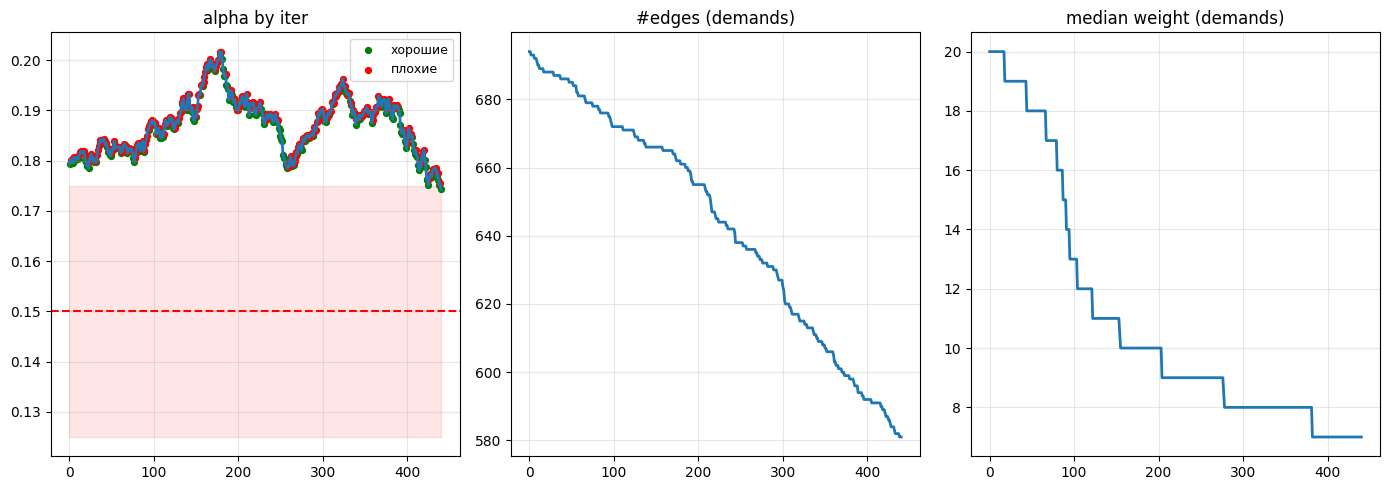

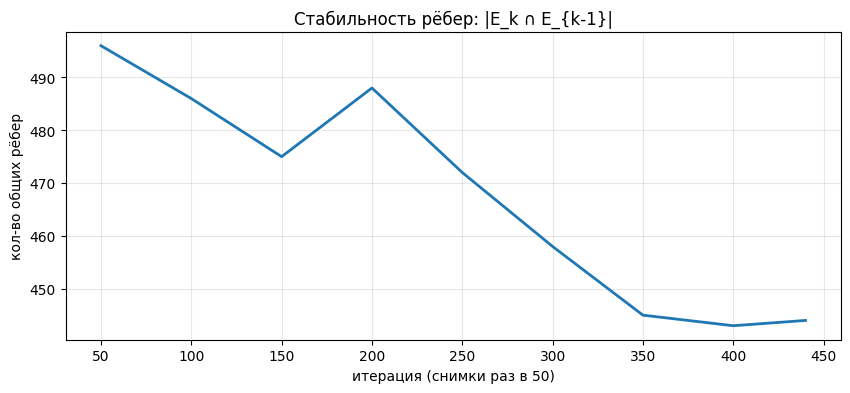

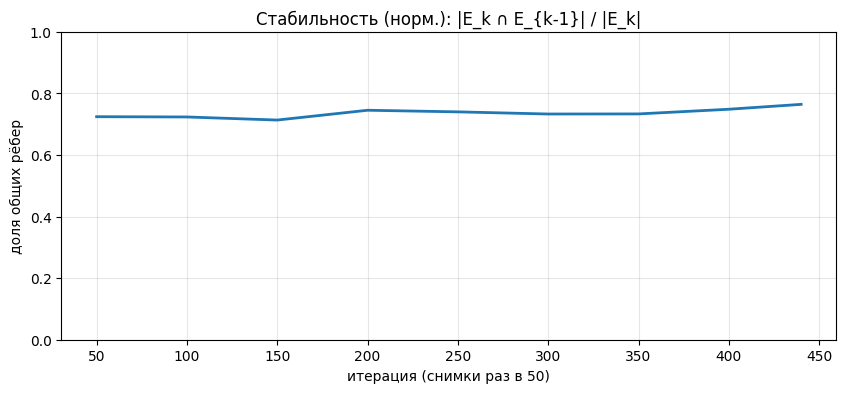

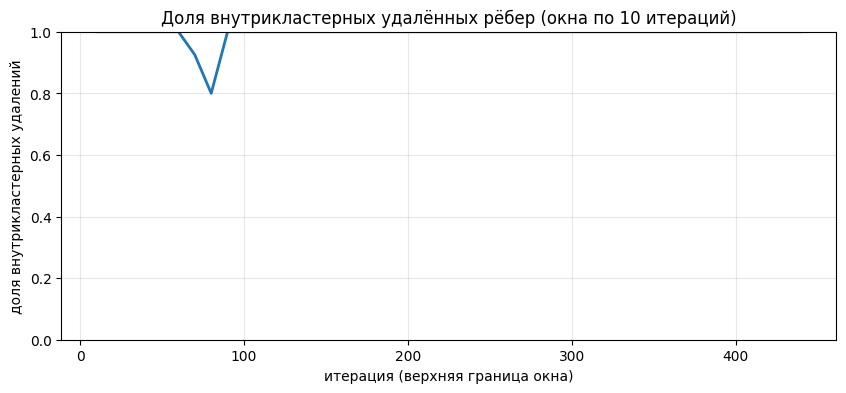

 метрика  initial  final
   edges      694    581
median_w       20      7
  mean_w       20      7
   sum_w    13859   3876


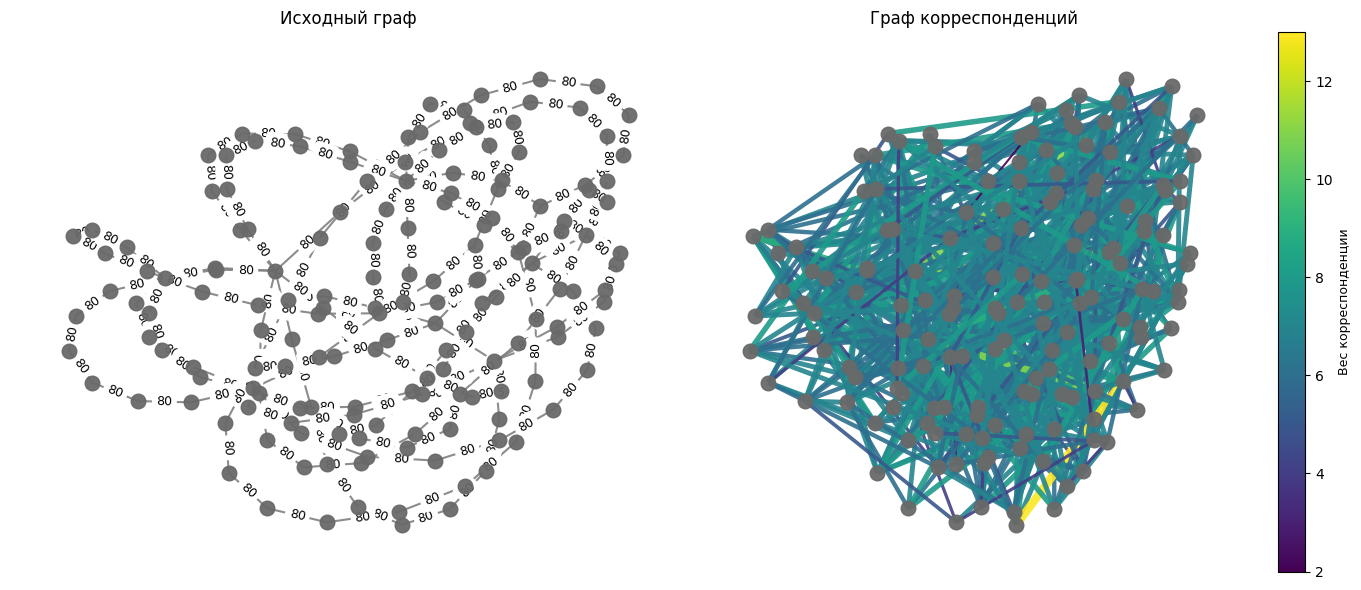

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 77.35 c
Итераций: 5532 (доля от максимума 16200 = 34.15%)
alpha_target=0.35, epsilon=0.025
initial_alpha=0.1848, final_alpha=0.3253, converged=True
Плохие шаги всего: 2745 (доля 0.50)
  — adversarial-плохих: 2745 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


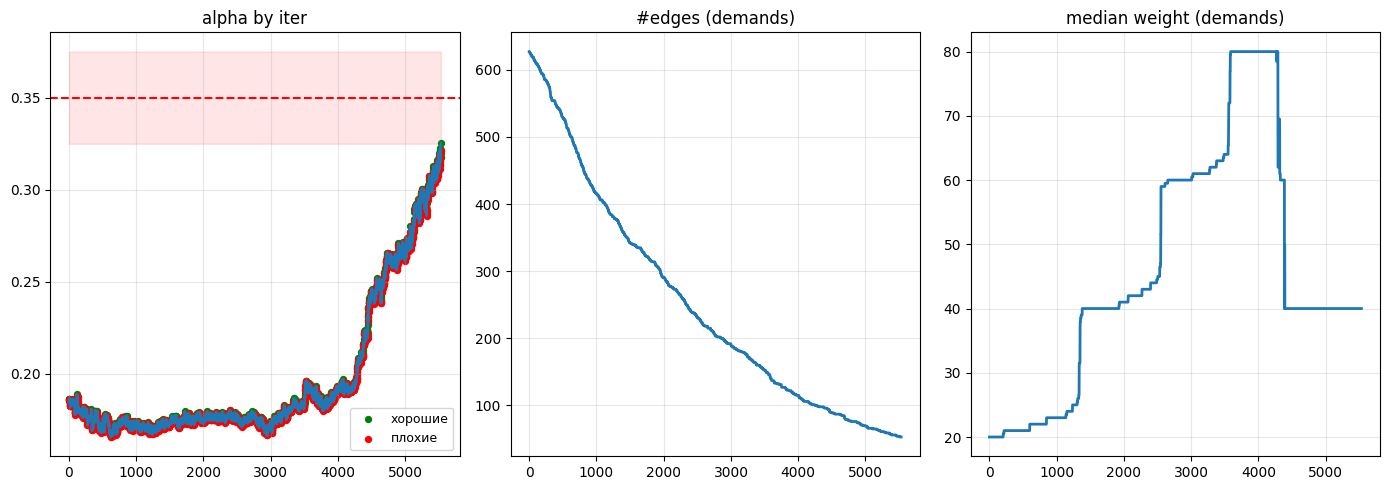

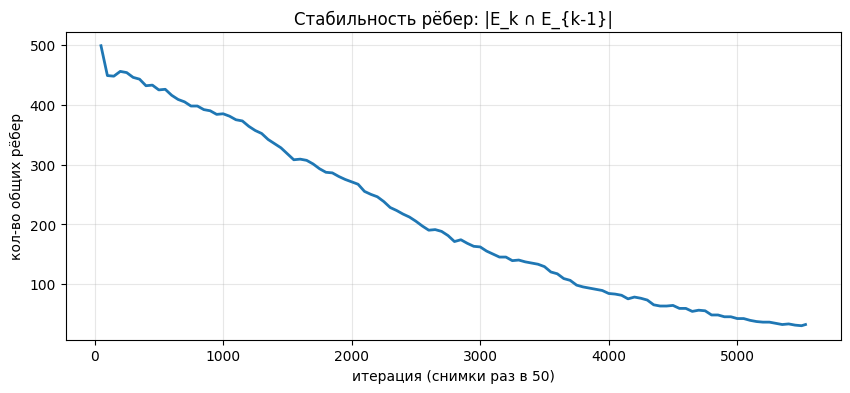

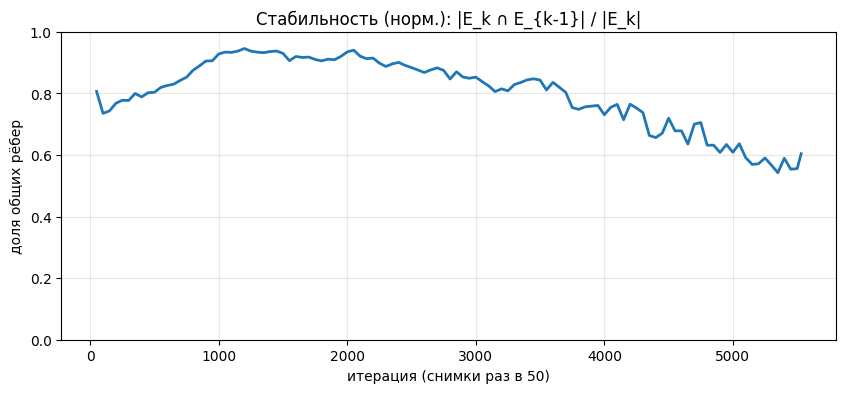

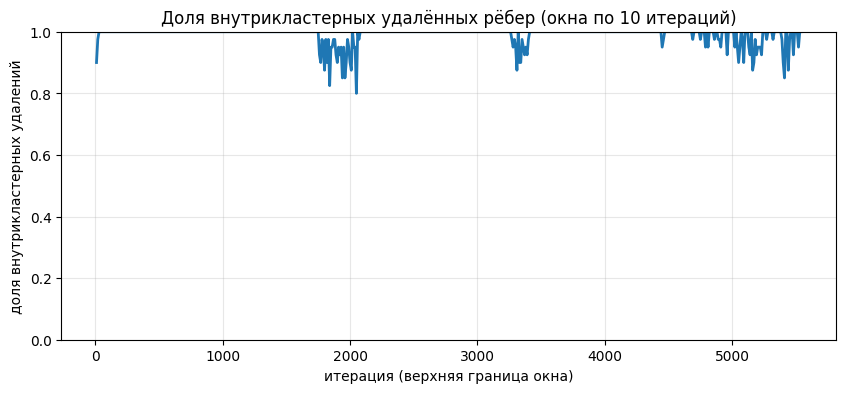

 метрика  initial  final
   edges      627     53
median_w       20     40
  mean_w       20     56
   sum_w    12618   2975


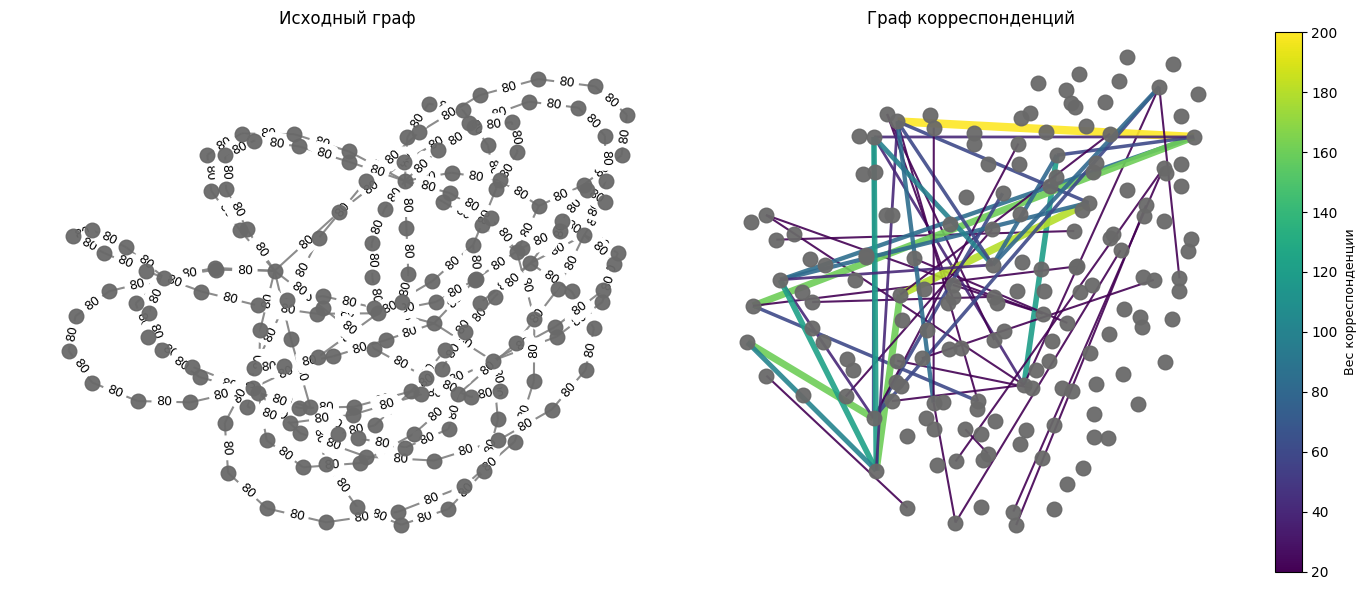

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 93.45 c
Итераций: 8928 (доля от максимума 16200 = 55.11%)
alpha_target=0.55, epsilon=0.025
initial_alpha=0.1900, final_alpha=0.5255, converged=True
Плохие шаги всего: 4470 (доля 0.50)
  — adversarial-плохих: 4470 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


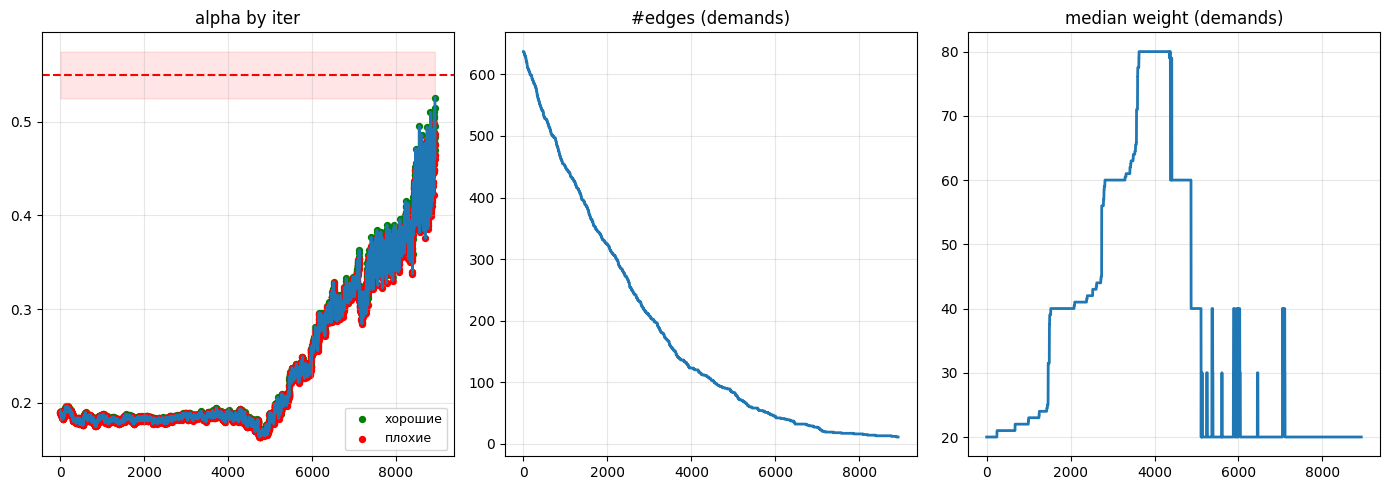

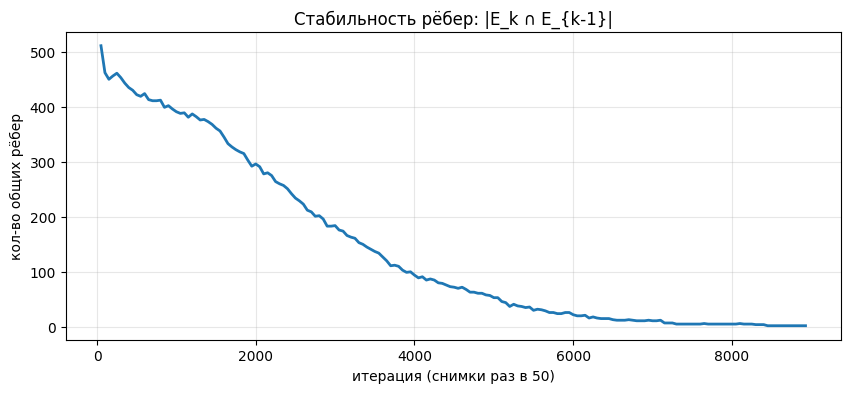

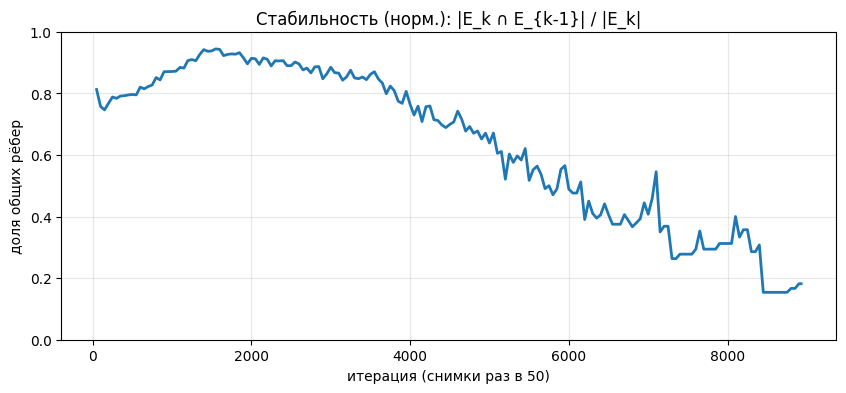

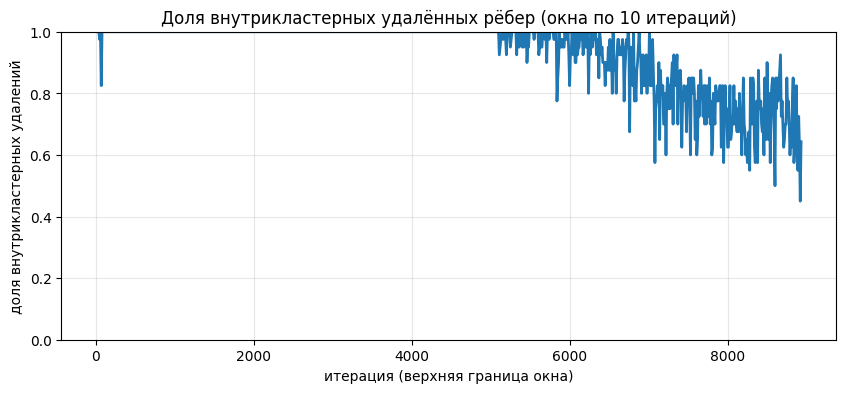

 метрика  initial  final
   edges      637     11
median_w       20     20
  mean_w       20     33
   sum_w    12688    360


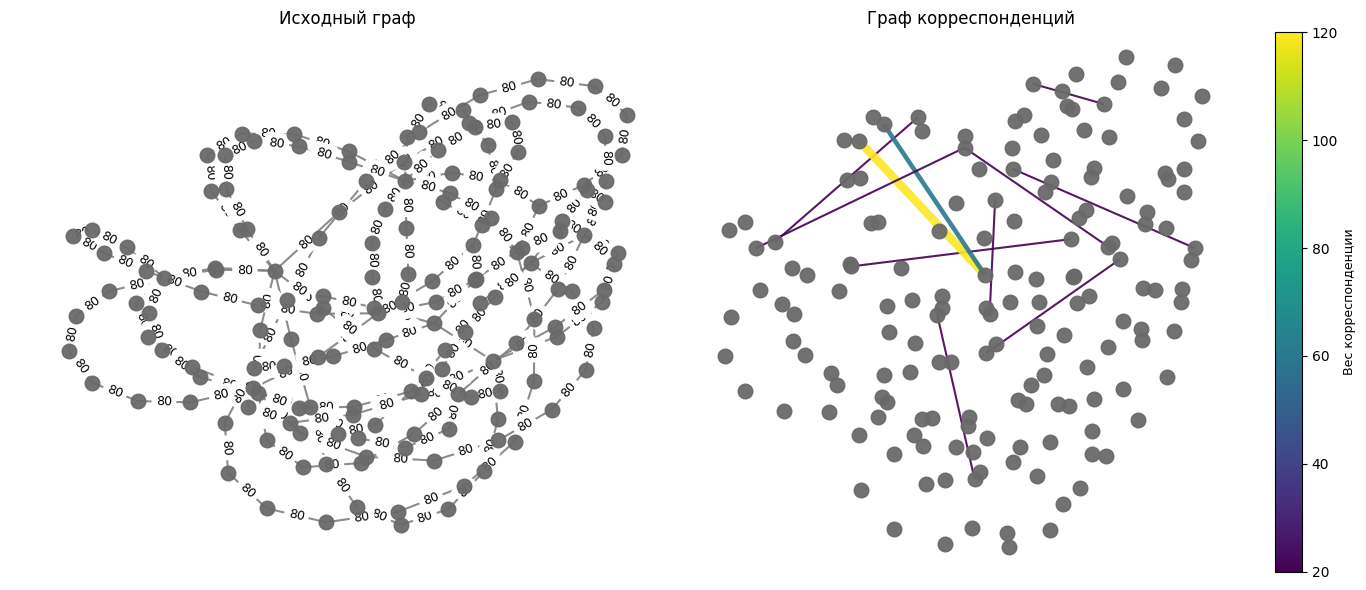

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 135.11 c
Итераций: 13304 (доля от максимума 16200 = 82.12%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.1820, final_alpha=0.7434, converged=True
Плохие шаги всего: 6650 (доля 0.50)
  — adversarial-плохих: 6650 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


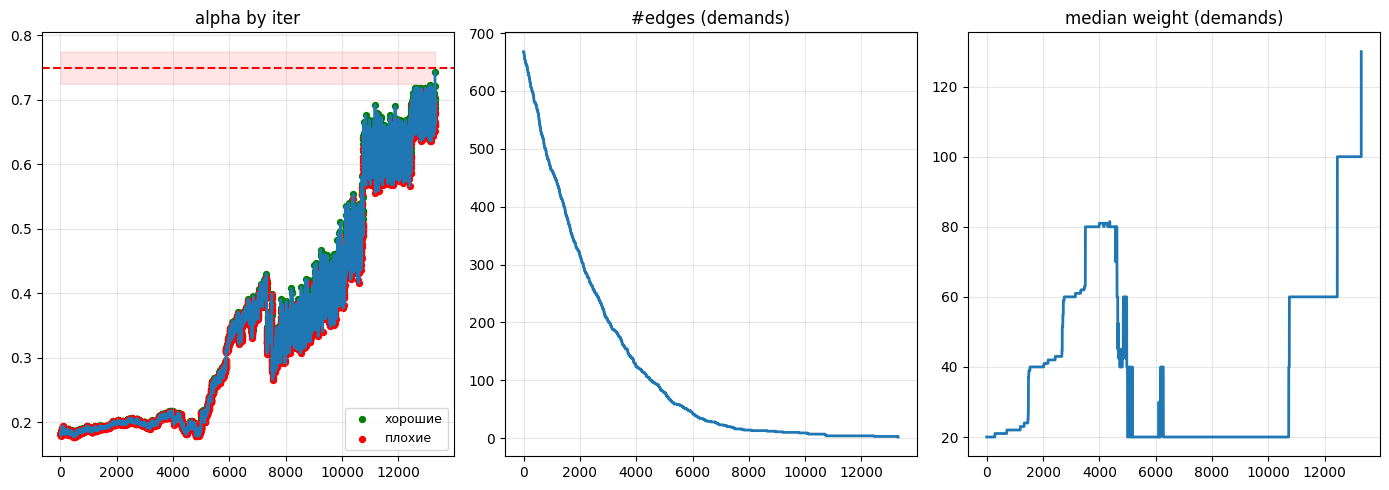

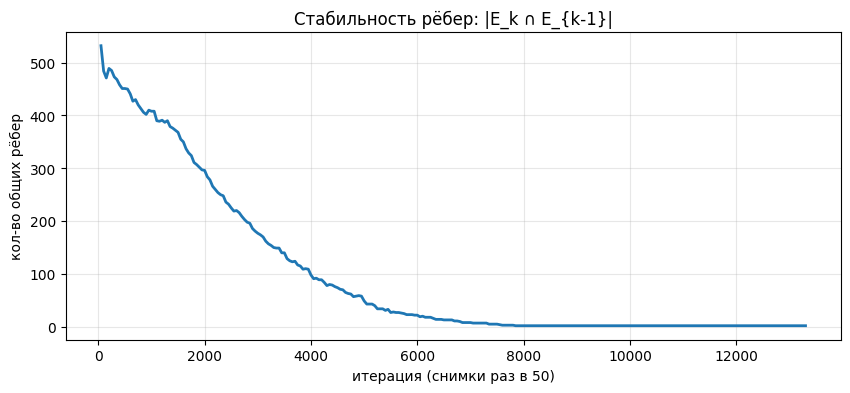

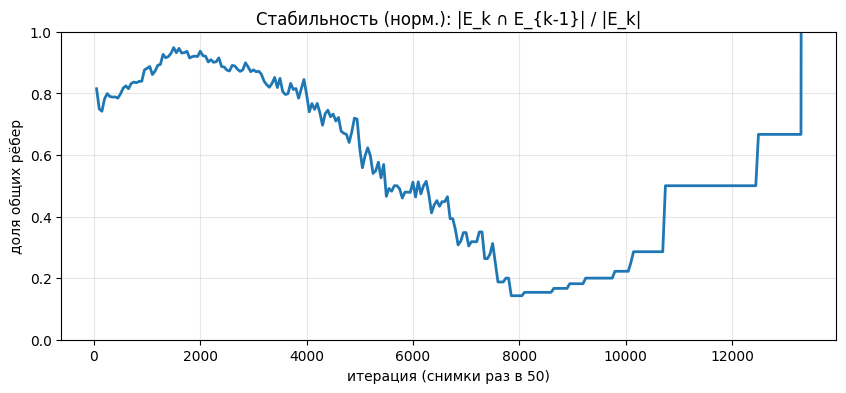

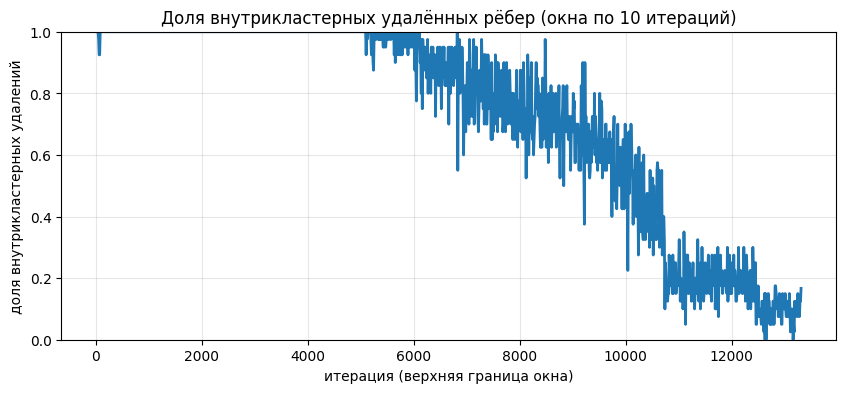

 метрика  initial  final
   edges      668      2
median_w       20    130
  mean_w       20    130
   sum_w    13264    260


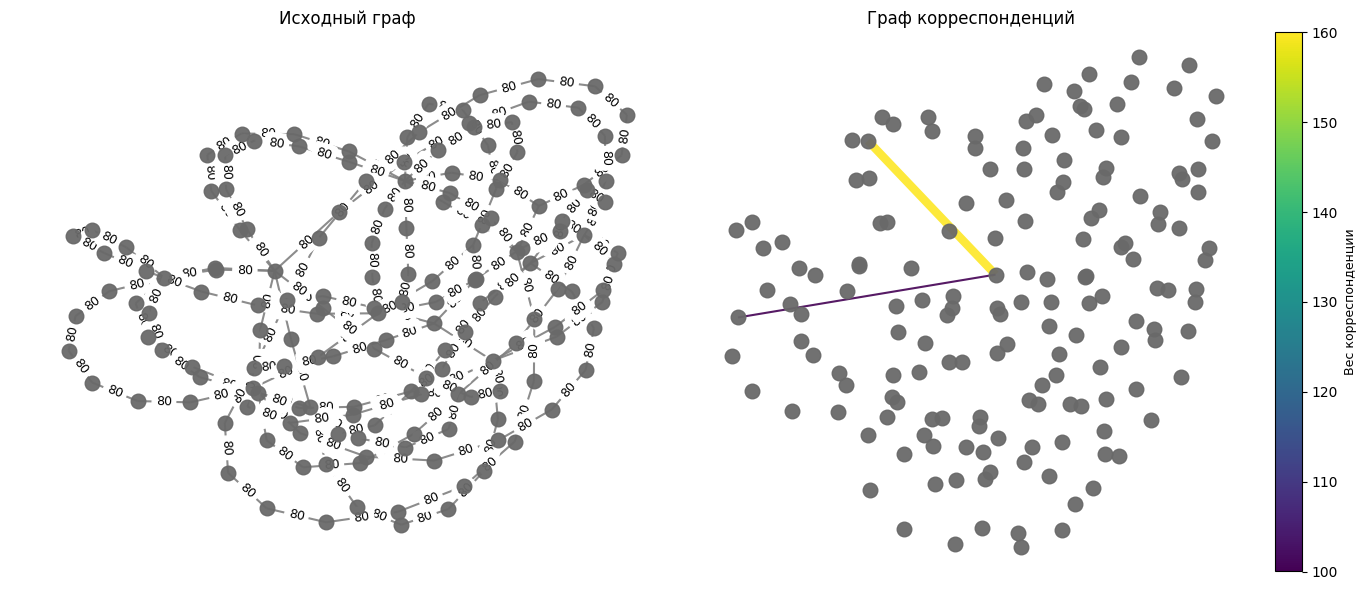

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 124.33 c
Итераций: 12000 (доля от максимума 16200 = 74.07%)
alpha_target=0.95, epsilon=0.025
initial_alpha=0.1794, final_alpha=0.9334, converged=True
Плохие шаги всего: 5974 (доля 0.50)
  — adversarial-плохих: 5974 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


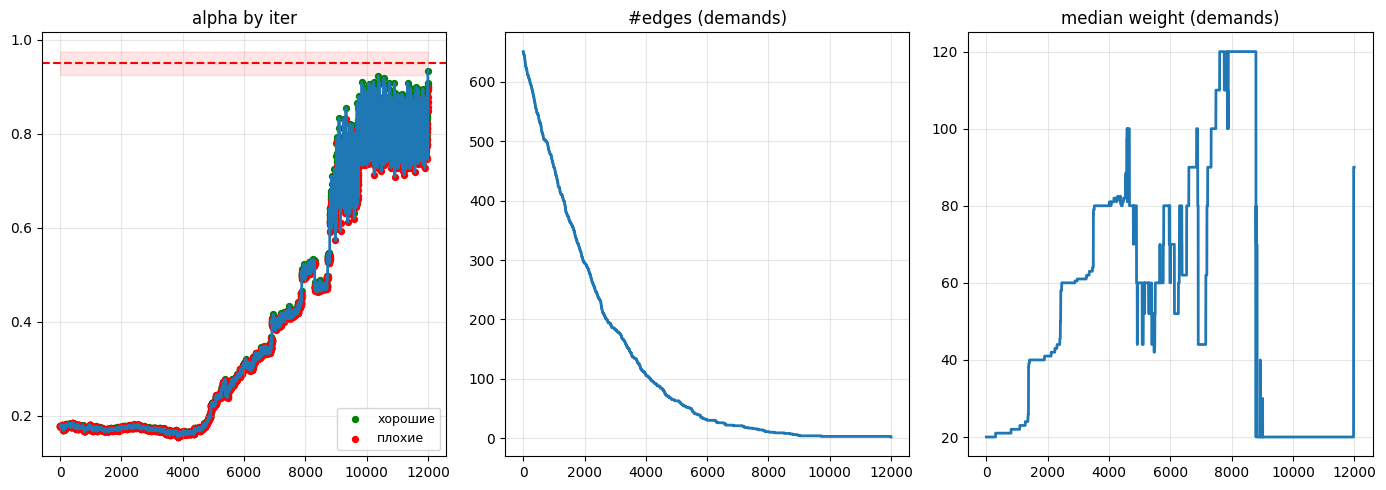

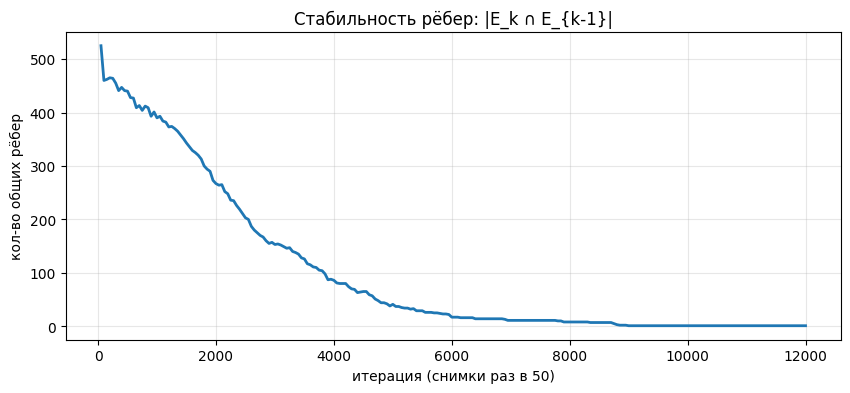

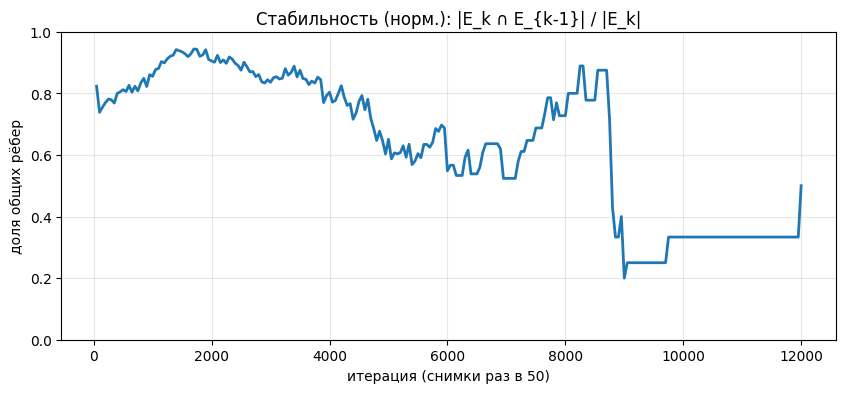

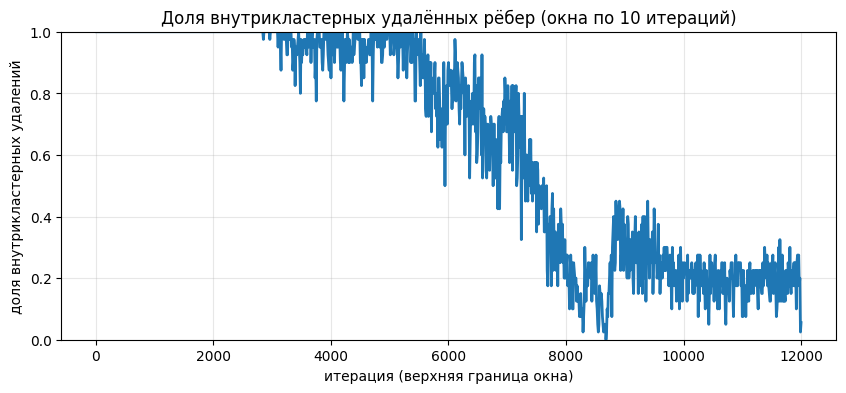

 метрика  initial  final
   edges      651      2
median_w       20     90
  mean_w       20     90
   sum_w    12957    180


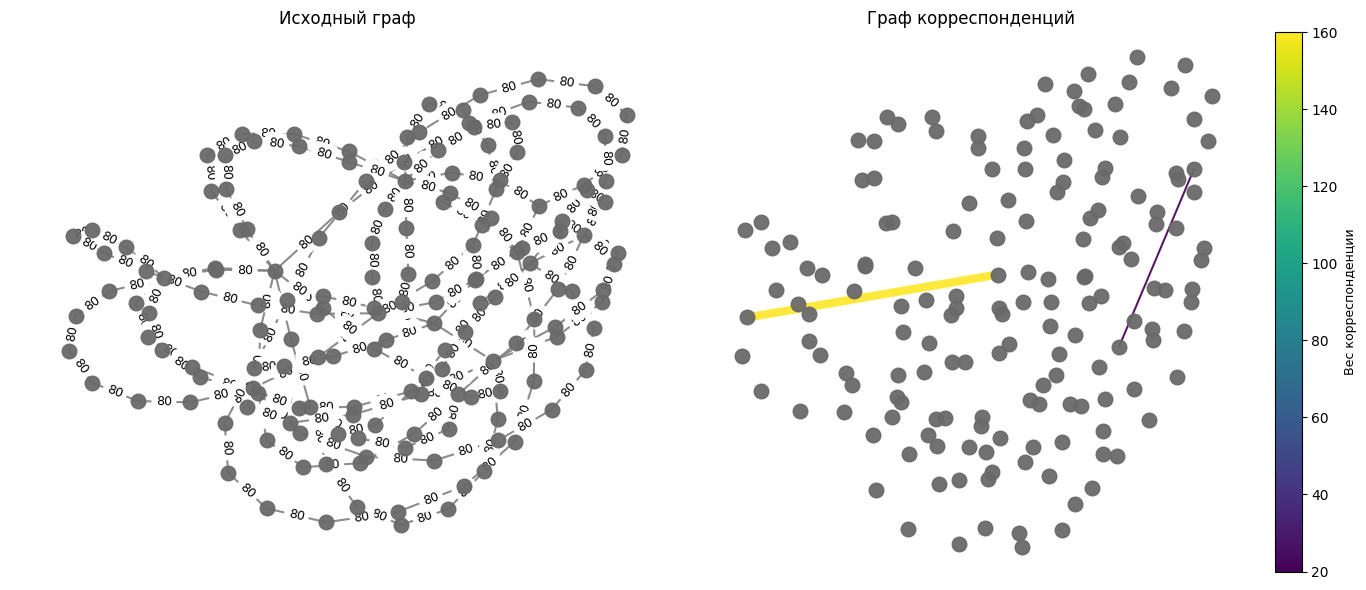



Решение MCF на итоге:
Значения gamma: alpha_target=0.15: 0.24806201549832269 alpha_target=0.35: 0.15624999971154707 alpha_target=0.55: 0.7272727271369018 alpha_target=0.75: 0.6153846153833571 alpha_target=0.95: 0.9999999995140516




In [49]:
alphas_batch = [0.15, 0.35, 0.55, 0.75, 0.95]

alphas_gamma = []
for alpha_target in alphas_batch:
  graph_for_mcf = GraphMCF(med_graph_for_test['adj_matrix'])
  gen = MCFGeneratorMultiEdges(epsilon=0.025,
                               p_ER = 0.05, distribution="normal", median_weight_for_initial=20, var_for_initial=5,
                               demands_median_denominator=8, demands_var_denominator=16,
                               num_edges=None, p_for_delete_edge=1.0, p_for_upsert_edge=1.0,)
  res = gen.generate(graph=graph_for_mcf, alpha_target=alpha_target)
  analyze_simple(graph_for_mcf, alpha_target=alpha_target, epsilon=0.025,
                 start_time=res.start_time, end_time=res.end_time,
                 alpha_history=res.alpha_history,
                 edge_counts_history=res.edge_counts_history,
                 median_weights_history=res.median_weights_history,
                 edge_mask_history=res.edge_mask_history,
                 edge_mask_snapshot_iters=res.edge_mask_snapshot_iters,
                 removal_events=res.removal_events,
                 algo_params=res.algo_params)
  graph_for_mcf.visualise_with_demands()
  sol = solve_throughput(graph_for_mcf.graph, graph_for_mcf.demands_laplacian)
  gamma = sol.gamma
  alphas_gamma.append(f"alpha_target={alpha_target}: {gamma}")
gamma_sequence = " ".join(alphas_gamma)
print(f"\n\nРешение MCF на итоге:\nЗначения gamma: {gamma_sequence}\n\n")